In [1]:
import logging
import os
from collections import OrderedDict
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt

from detectron2.config import get_cfg
from detectron2.model_zoo import get_config_file, get_checkpoint_url
from detectron2.engine import DefaultTrainer, hooks
from detectron2.evaluation import COCOEvaluator
from detectron2.modeling import GeneralizedRCNNWithTTA
from detectron2.data.datasets.coco import register_coco_instances
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.data.catalog import MetadataCatalog

/home/zack/anaconda3/envs/riverside/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Detectron2

Detectron2 is my choice of framework to use for this object detection task. The below cell implements a custom trainer that works on COCO formatted data.

In [2]:
class Trainer(DefaultTrainer):
    """
    We use the "DefaultTrainer" which contains pre-defined default logic for
    standard training workflow. They may not work for you, especially if you
    are working on a new research project. In that case you can write your
    own training loop. You can use "tools/plain_train_net.py" as an example.
    """

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return [COCOEvaluator(dataset_name, output_dir=output_folder)]

    @classmethod
    def test_with_TTA(cls, cfg, model):
        logger = logging.getLogger("detectron2.trainer")
        # In the end of training, run an evaluation with TTA
        # Only support some R-CNN models.
        logger.info("Running inference with test-time augmentation ...")
        model = GeneralizedRCNNWithTTA(cfg, model)
        evaluators = [
            cls.build_evaluator(
                cfg, name, output_folder=os.path.join(cfg.OUTPUT_DIR, "inference_TTA")
            )
            for name in cfg.DATASETS.TEST
        ]
        res = cls.test(cfg, model, evaluators)
        res = OrderedDict({k + "_TTA": v for k, v in res.items()})
        return res

# Construct the configuration

Detectron2 provides a flat-file interface, so that's what we'll be setting up in the below cells.

In [3]:
cfg = get_cfg()

# Initial model selection

A good baseline will be utilizing a Faster-RCNN with an FPN. The Faster RCNN is a two-stage object detector that has set many benchmarks over the years and still provides robust performance in the era of enhanced single-stage detectors. The FPN provides multi-scale feature maps to enhance scale invariance of the resulting detector, which is less of a concern with this dataset since all of the data is hand held imagery and the objects are fairly uniform in scale (unlike in overhead imagery). We'll use a Resnet50 as the backbone because it provides decent feature extraction performance without being computationally or memory intensive. Lets load the configuration for the R50 Faster-RCNN FPN now.

In [4]:
cfg.merge_from_file(get_config_file('COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml'))

# Setup our data configuration

Below, we are simply defining the names of the datasets we wish to use. These datasets have not been registered yet, but we will do that in the cell after. I'm going to use 8 workers because I have a CPU with 12 cores and want to ensure I have enough processes loading data to saturate the PCIE/GPU without overtaxing my system and causing stuttering.

In [5]:
cfg.DATASETS.TRAIN = ('manu_id_train',)
cfg.DATASETS.TEST = ('manu_id_val',)
cfg.DATALOADER.NUM_WORKERS = 8

## Register the dataset

The cell below is where the dataset is registered by name (matching the names we defined above). To do this, we simply register the directory containing the imagery and the COCO json files we created previously. Since we are training, we want to register the train and validation sets. The validation set will allow us to evaluate our model at intermediate phases throughout training and perform model selection. Since we are using the val set to select our best model, it should **not** be the same dataset we ultimately evaluate our model on (that will be the test set).

In [6]:
image_root = '/home/zack/datasets/manufacturer_identification/data/images'
register_coco_instances('manu_id_train', {}, image_root=image_root, json_file='/home/zack/datasets/manufacturer_identification/data/coco/train.json')
register_coco_instances('manu_id_val', {}, image_root=image_root, json_file='/home/zack/datasets/manufacturer_identification/data/coco/val.json')

# Define the model weights we wish to use for initialization

Initialization of object detectors is a massively explored sub-field of machine learning. In some cases, random initialization is okay to use, but utilizing pre-trained feature extractors (e.g. Resnet50) or full pre-trained networks (e.g. Faster-RCNN FPN) regularly provides superior performance to random initialization. There are several various pretraining regimes, of which the most populare are taking 1. Imagenet pretrained feature extractors (recognition task), 2. COCO/other detection dataset pretrained detectors (detection task), or 3. Self-supervised pretrained feature extractors (recognition task). Generally, the recognition pretrained feature extractors provide robust feature extraction capabilities and a strong starting point for optimization to take over. However, one challenge is that the remainder of the network (FPN Llteral connections, RPN, Box/Mask/Classifier heads) is still randomly initialized. Additionally, pre-training on recognition tasks often doesn't require scale information to the same level as an object detector, meaning some features may be useless/uninformative.

Using a full pretrained network is in most ways superior to a simple pretrained feature extractor. Recent work has focused on unsupervised object detection training using Selective Search or properties of DETR, but these are still early techniques. For our application and for the sake of time/complexity, I will load the weights for a R50 Faster-RCNN FPN that was pretrained on the COCO dataset with Large Scale Jitter, which is a new augmentation and learning schedule that has shown large performance benefits.

In [19]:
# Large scale jitter likely won't help us here since most objects are at the same scale, but lets load the R50-FasterRCNN-FPN LSJ model weights as a good pretrained starting point.
cfg.MODEL.WEIGHTS = get_checkpoint_url('new_baselines/mask_rcnn_R_50_FPN_400ep_LSJ.py')

# Set the number of classes

The problem description says there are 41 classes, but I only see 30 classes in the labels.txt file and in the unique values of the box_labels.txt file

In [20]:
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 30

# Define our training schedule

Since this dataset isn't very large, we likely don't need to train for very long. I'm also pressed on time, so shorter training runs are better. 40,000 iterations seems like a reasonable place to start, but even that is likely too many iterations to train and will likely lead to overfitting. As mentioned above, one way to avoid overfitting is through utilizing a validation dataset. Detectron2 performs intermediate validation, but doesn't checkpoint based on the metric (unfortunately). After training, it will be up to us to determine the best model based on the logged metrics. Lets set the batch size to 6 (RTX 3090), and lets step the learning rate down at a schedule of 25000 and 35000 iterations. This will reduce the learning rate by some gamma (0.1) at these iterations, ideally model improving convergence as we approach a minima (hopefully the global minima and not a pesky local minima. CosineScheduler/Cyclic learning rates could help us get around that, but Detectron2 doesn't support those currently).

In [21]:
cfg.SOLVER.MAX_ITER = 40000
cfg.SOLVER.STEPS = (25000, 35000)
cfg.SOLVER.IMS_PER_BATCH = 6
# Checkpoint at a 1:1 ratio with evaluation
cfg.SOLVER.CHECKPOINT_PERIOD = 1000
cfg.TEST.EVAL_PERIOD = 1000

# Train the model

Train the model, making sure to load the weights we specified above.

In [10]:
"""
If you'd like to do anything fancier than the standard training logic,
consider writing your own training loop (see plain_train_net.py) or
subclassing the trainer.
"""
trainer = Trainer(cfg)
trainer.resume_or_load(resume=False)
if cfg.TEST.AUG.ENABLED:
    trainer.register_hooks(
        [hooks.EvalHook(0, lambda: trainer.test_with_TTA(cfg, trainer.model))]
    )

trainer.train()

[04/21 08:29:47 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

WARNING [04/21 08:29:47 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/21 08:29:47 d2.data.datasets.coco]: Loaded 3334 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/train.json
[04/21 08:29:47 d2.data.build]: Removed 0 images with no usable annotations. 3334 images left.
[04/21 08:29:47 d2.data.build]: Distribution of instances among all 30 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
|      ATR      | 66           |    Airbus     | 434          |    Antonov    | 34           |
|  Beechcraft   | 67           |    Boeing     | 733          | Bombardier .. | 33           |
| British Aer.. | 133          |   Canadair    | 134          |    Cessna     | 133          |
| Cirrus Airc.. | 33           | Dassault Av.. | 67          

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (31, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (31,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (120, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (120,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.bias
backbone.fpn_lateral3.bias
backbone.fpn_lateral4.bias
backb

[04/21 08:29:47 d2.engine.train_loop]: Starting training from iteration 0


/home/zack/anaconda3/envs/riverside/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/zack/anaconda3/envs/riverside/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272068694/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/21 08:29:57 d2.utils.events]:  eta: 4:24:59  iter: 19  total_loss: 0.3082  loss_cls: 0.1087  loss_box_reg: 0.0008618  loss_rpn_cls: 0.1228  loss_rpn_loc: 0.04424  time: 0.3903  data_time: 0.0202  lr: 0.00039962  max_mem: 6290M
[04/21 08:30:05 d2.utils.events]:  eta: 4:27:33  iter: 39  total_loss: 0.2109  loss_cls: 0.1055  loss_box_reg: 0.07335  loss_rpn_cls: 0.0151  loss_rpn_loc: 0.02296  time: 0.3974  data_time: 0.0058  lr: 0.00079922  max_mem: 6290M
[04/21 08:30:13 d2.utils.events]:  eta: 4:27:28  iter: 59  total_loss: 0.2273  loss_cls: 0.1161  loss_box_reg: 0.08327  loss_rpn_cls: 0.008703  loss_rpn_loc: 0.01306  time: 0.3989  data_time: 0.0057  lr: 0.0011988  max_mem: 6290M
[04/21 08:30:21 d2.utils.events]:  eta: 4:29:54  iter: 79  total_loss: 0.2137  loss_cls: 0.1089  loss_box_reg: 0.08277  loss_rpn_cls: 0.005407  loss_rpn_loc: 0.009747  time: 0.4023  data_time: 0.0056  lr: 0.0015984  max_mem: 6290M
[04/21 08:30:29 d2.utils.events]:  eta: 4:31:20  iter: 99  total_loss: 0.2327  

[04/21 08:34:43 d2.utils.events]:  eta: 4:28:33  iter: 719  total_loss: 0.2061  loss_cls: 0.1336  loss_box_reg: 0.05737  loss_rpn_cls: 0.001068  loss_rpn_loc: 0.007762  time: 0.4079  data_time: 0.0058  lr: 0.014386  max_mem: 6290M
[04/21 08:34:51 d2.utils.events]:  eta: 4:28:21  iter: 739  total_loss: 0.1965  loss_cls: 0.1367  loss_box_reg: 0.04994  loss_rpn_cls: 0.001172  loss_rpn_loc: 0.00919  time: 0.4077  data_time: 0.0059  lr: 0.014785  max_mem: 6290M
[04/21 08:34:59 d2.utils.events]:  eta: 4:28:09  iter: 759  total_loss: 0.1754  loss_cls: 0.1153  loss_box_reg: 0.05017  loss_rpn_cls: 0.001899  loss_rpn_loc: 0.009233  time: 0.4077  data_time: 0.0058  lr: 0.015185  max_mem: 6290M
[04/21 08:35:07 d2.utils.events]:  eta: 4:27:59  iter: 779  total_loss: 0.1877  loss_cls: 0.1223  loss_box_reg: 0.05037  loss_rpn_cls: 0.0009502  loss_rpn_loc: 0.006768  time: 0.4076  data_time: 0.0058  lr: 0.015584  max_mem: 6290M
[04/21 08:35:15 d2.utils.events]:  eta: 4:27:51  iter: 799  total_loss: 0.16

[04/21 08:37:53 d2.evaluation.evaluator]: Inference done 2452/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:27
[04/21 08:37:58 d2.evaluation.evaluator]: Inference done 2615/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:22
[04/21 08:38:03 d2.evaluation.evaluator]: Inference done 2777/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:17
[04/21 08:38:08 d2.evaluation.evaluator]: Inference done 2941/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:12
[04/21 08:38:13 d2.evaluation.evaluator]: Inference done 3105/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:07
[04/21 08:38:18 d2.evaluation.evaluator]: Inference done 3269/3333. Dataloading: 0.0007 s/iter. Inference: 0.0299 s

[04/21 08:40:07 d2.utils.events]:  eta: 4:24:35  iter: 1259  total_loss: 0.1228  loss_cls: 0.08245  loss_box_reg: 0.02918  loss_rpn_cls: 0.00105  loss_rpn_loc: 0.00829  time: 0.4074  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 08:40:15 d2.utils.events]:  eta: 4:24:27  iter: 1279  total_loss: 0.1187  loss_cls: 0.07918  loss_box_reg: 0.02896  loss_rpn_cls: 0.001178  loss_rpn_loc: 0.008312  time: 0.4074  data_time: 0.0058  lr: 0.02  max_mem: 6290M
[04/21 08:40:24 d2.utils.events]:  eta: 4:24:27  iter: 1299  total_loss: 0.1202  loss_cls: 0.08027  loss_box_reg: 0.02805  loss_rpn_cls: 0.0008075  loss_rpn_loc: 0.007273  time: 0.4075  data_time: 0.0058  lr: 0.02  max_mem: 6290M
[04/21 08:40:32 d2.utils.events]:  eta: 4:24:19  iter: 1319  total_loss: 0.1165  loss_cls: 0.07675  loss_box_reg: 0.02922  loss_rpn_cls: 0.000892  loss_rpn_loc: 0.006717  time: 0.4073  data_time: 0.0059  lr: 0.02  max_mem: 6290M
[04/21 08:40:40 d2.utils.events]:  eta: 4:24:11  iter: 1339  total_loss: 0.1349  loss

[04/21 08:44:48 d2.utils.events]:  eta: 4:18:42  iter: 1959  total_loss: 0.09431  loss_cls: 0.06162  loss_box_reg: 0.02464  loss_rpn_cls: 0.0006047  loss_rpn_loc: 0.005223  time: 0.4050  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 08:44:56 d2.utils.events]:  eta: 4:18:14  iter: 1979  total_loss: 0.1027  loss_cls: 0.06336  loss_box_reg: 0.02599  loss_rpn_cls: 0.0005678  loss_rpn_loc: 0.007249  time: 0.4049  data_time: 0.0060  lr: 0.02  max_mem: 6290M
WARNING [04/21 08:45:04 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/21 08:45:04 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/21 08:45:04 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/21 08:45:04 d2.data.common]: Serializing 3333 elements to byte tensors a

[04/21 08:46:48 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/21 08:46:48 d2.evaluation.testing]: copypaste: Task: bbox
[04/21 08:46:48 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/21 08:46:48 d2.evaluation.testing]: copypaste: 23.3673,29.6861,28.0161,nan,0.0000,23.3734
[04/21 08:46:48 d2.utils.events]:  eta: 4:18:02  iter: 1999  total_loss: 0.09629  loss_cls: 0.06413  loss_box_reg: 0.02377  loss_rpn_cls: 0.0007006  loss_rpn_loc: 0.006007  time: 0.4048  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 08:46:57 d2.utils.events]:  eta: 4:17:56  iter: 2019  total_loss: 0.1096  loss_cls: 0.0734  loss_box_reg: 0.02846  loss_rpn_cls: 0.0005646  loss_rpn_loc: 0.006639  time: 0.4048  data_time: 0.0058  lr: 0.02  max_mem: 6290M
[04/21 08:47:05 d2.utils.events]:  eta: 4:17:48  iter: 2039  total_loss: 0.109  loss_cls: 0.07347  loss_box_reg: 0.02845  loss_rpn_cls: 0.000683  loss_rpn_loc: 0.008697  time: 0.4049  data_time: 0.0061  lr: 0.02  max_mem:

[04/21 08:51:13 d2.utils.events]:  eta: 4:12:25  iter: 2659  total_loss: 0.09876  loss_cls: 0.05701  loss_box_reg: 0.02828  loss_rpn_cls: 0.0005878  loss_rpn_loc: 0.006074  time: 0.4038  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 08:51:21 d2.utils.events]:  eta: 4:12:16  iter: 2679  total_loss: 0.09714  loss_cls: 0.06345  loss_box_reg: 0.02786  loss_rpn_cls: 0.0005717  loss_rpn_loc: 0.005984  time: 0.4037  data_time: 0.0064  lr: 0.02  max_mem: 6290M
[04/21 08:51:29 d2.utils.events]:  eta: 4:12:05  iter: 2699  total_loss: 0.09157  loss_cls: 0.05612  loss_box_reg: 0.02959  loss_rpn_cls: 0.000654  loss_rpn_loc: 0.005372  time: 0.4037  data_time: 0.0059  lr: 0.02  max_mem: 6290M
[04/21 08:51:37 d2.utils.events]:  eta: 4:12:08  iter: 2719  total_loss: 0.1098  loss_cls: 0.06962  loss_box_reg: 0.03249  loss_rpn_cls: 0.0008148  loss_rpn_loc: 0.006902  time: 0.4037  data_time: 0.0062  lr: 0.02  max_mem: 6290M
[04/21 08:51:45 d2.utils.events]:  eta: 4:12:04  iter: 2739  total_loss: 0.111

[04/21 08:55:07 d2.evaluation.evaluator]: Inference done 3100/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:07
[04/21 08:55:12 d2.evaluation.evaluator]: Inference done 3262/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:02
[04/21 08:55:14 d2.evaluation.evaluator]: Total inference time: 0:01:42.790563 (0.030887 s / iter per device, on 1 devices)
[04/21 08:55:14 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:39 (0.029995 s / iter per device, on 1 devices)
[04/21 08:55:14 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/21 08:55:14 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[04/21 08:55:14 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[04/21 08:55:

[04/21 08:57:25 d2.utils.events]:  eta: 4:08:11  iter: 3319  total_loss: 0.07127  loss_cls: 0.04111  loss_box_reg: 0.02214  loss_rpn_cls: 0.0002413  loss_rpn_loc: 0.005215  time: 0.4038  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 08:57:32 d2.utils.events]:  eta: 4:07:58  iter: 3339  total_loss: 0.07237  loss_cls: 0.03946  loss_box_reg: 0.02179  loss_rpn_cls: 0.0003842  loss_rpn_loc: 0.005236  time: 0.4037  data_time: 0.0059  lr: 0.02  max_mem: 6290M
[04/21 08:57:40 d2.utils.events]:  eta: 4:07:47  iter: 3359  total_loss: 0.0634  loss_cls: 0.0344  loss_box_reg: 0.02198  loss_rpn_cls: 0.0004115  loss_rpn_loc: 0.005742  time: 0.4037  data_time: 0.0058  lr: 0.02  max_mem: 6290M
[04/21 08:57:49 d2.utils.events]:  eta: 4:07:44  iter: 3379  total_loss: 0.06393  loss_cls: 0.03034  loss_box_reg: 0.02304  loss_rpn_cls: 0.0002699  loss_rpn_loc: 0.005559  time: 0.4037  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 08:57:57 d2.utils.events]:  eta: 4:07:35  iter: 3399  total_loss: 0.060

[04/21 09:01:57 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/21 09:01:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/21 09:01:57 d2.data.common]: Serializing 3333 elements to byte tensors and concatenating them all ...
[04/21 09:01:57 d2.data.common]: Serialized dataset takes 0.85 MiB
[04/21 09:01:57 d2.evaluation.evaluator]: Start inference on 3333 batches
[04/21 09:01:58 d2.evaluation.evaluator]: Inference done 11/3333. Dataloading: 0.0005 s/iter. Inference: 0.0302 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:01:42
[04/21 09:02:03 d2.evaluation.evaluator]: Inference done 174/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:01:37
[04/21 09:02:08 d2.evaluation.evaluator]: Inference done 337/3333. Dataloadin

[04/21 09:03:41 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/21 09:03:41 d2.evaluation.testing]: copypaste: Task: bbox
[04/21 09:03:41 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/21 09:03:41 d2.evaluation.testing]: copypaste: 60.0472,77.0746,71.3798,nan,0.0000,60.0582
[04/21 09:03:41 d2.utils.events]:  eta: 4:03:32  iter: 3999  total_loss: 0.05745  loss_cls: 0.03242  loss_box_reg: 0.02101  loss_rpn_cls: 0.0002209  loss_rpn_loc: 0.005711  time: 0.4031  data_time: 0.0059  lr: 0.02  max_mem: 6290M
[04/21 09:03:49 d2.utils.events]:  eta: 4:03:15  iter: 4019  total_loss: 0.07438  loss_cls: 0.03421  loss_box_reg: 0.02526  loss_rpn_cls: 0.0004689  loss_rpn_loc: 0.006856  time: 0.4031  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 09:03:57 d2.utils.events]:  eta: 4:02:56  iter: 4039  total_loss: 0.06735  loss_cls: 0.03189  loss_box_reg: 0.02552  loss_rpn_cls: 0.0003063  loss_rpn_loc: 0.006228  time: 0.4030  data_time: 0.0060  lr: 0.02  max

[04/21 09:08:06 d2.utils.events]:  eta: 3:58:22  iter: 4659  total_loss: 0.05783  loss_cls: 0.02649  loss_box_reg: 0.02207  loss_rpn_cls: 0.0004023  loss_rpn_loc: 0.005153  time: 0.4028  data_time: 0.0057  lr: 0.02  max_mem: 6290M
[04/21 09:08:14 d2.utils.events]:  eta: 3:58:15  iter: 4679  total_loss: 0.07249  loss_cls: 0.0346  loss_box_reg: 0.02379  loss_rpn_cls: 0.0008836  loss_rpn_loc: 0.007785  time: 0.4028  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 09:08:22 d2.utils.events]:  eta: 3:58:07  iter: 4699  total_loss: 0.06924  loss_cls: 0.03491  loss_box_reg: 0.02562  loss_rpn_cls: 0.0003744  loss_rpn_loc: 0.006174  time: 0.4028  data_time: 0.0059  lr: 0.02  max_mem: 6290M
[04/21 09:08:30 d2.utils.events]:  eta: 3:57:59  iter: 4719  total_loss: 0.05817  loss_cls: 0.02214  loss_box_reg: 0.02422  loss_rpn_cls: 0.000129  loss_rpn_loc: 0.006176  time: 0.4027  data_time: 0.0059  lr: 0.02  max_mem: 6290M
[04/21 09:08:38 d2.utils.events]:  eta: 3:57:49  iter: 4739  total_loss: 0.053

[04/21 09:11:59 d2.evaluation.evaluator]: Inference done 3101/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:07
[04/21 09:12:04 d2.evaluation.evaluator]: Inference done 3264/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:02
[04/21 09:12:06 d2.evaluation.evaluator]: Total inference time: 0:01:42.649049 (0.030844 s / iter per device, on 1 devices)
[04/21 09:12:06 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:39 (0.029955 s / iter per device, on 1 devices)
[04/21 09:12:06 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/21 09:12:06 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[04/21 09:12:06 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[04/21 09:12:

[04/21 09:14:14 d2.utils.events]:  eta: 3:53:54  iter: 5319  total_loss: 0.05893  loss_cls: 0.02482  loss_box_reg: 0.02375  loss_rpn_cls: 0.0002037  loss_rpn_loc: 0.006826  time: 0.4023  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 09:14:22 d2.utils.events]:  eta: 3:53:47  iter: 5339  total_loss: 0.04953  loss_cls: 0.02224  loss_box_reg: 0.01962  loss_rpn_cls: 0.0002094  loss_rpn_loc: 0.005782  time: 0.4023  data_time: 0.0059  lr: 0.02  max_mem: 6290M
[04/21 09:14:30 d2.utils.events]:  eta: 3:53:40  iter: 5359  total_loss: 0.06257  loss_cls: 0.02924  loss_box_reg: 0.02644  loss_rpn_cls: 0.0002896  loss_rpn_loc: 0.005671  time: 0.4023  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 09:14:38 d2.utils.events]:  eta: 3:53:32  iter: 5379  total_loss: 0.05303  loss_cls: 0.0226  loss_box_reg: 0.02272  loss_rpn_cls: 0.0003799  loss_rpn_loc: 0.005408  time: 0.4023  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 09:14:46 d2.utils.events]:  eta: 3:53:24  iter: 5399  total_loss: 0.05

[04/21 09:18:47 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/21 09:18:47 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/21 09:18:47 d2.data.common]: Serializing 3333 elements to byte tensors and concatenating them all ...
[04/21 09:18:47 d2.data.common]: Serialized dataset takes 0.85 MiB
[04/21 09:18:47 d2.evaluation.evaluator]: Start inference on 3333 batches
[04/21 09:18:47 d2.evaluation.evaluator]: Inference done 11/3333. Dataloading: 0.0007 s/iter. Inference: 0.0306 s/iter. Eval: 0.0001 s/iter. Total: 0.0315 s/iter. ETA=0:01:44
[04/21 09:18:52 d2.evaluation.evaluator]: Inference done 173/3333. Dataloading: 0.0007 s/iter. Inference: 0.0301 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:01:37
[04/21 09:18:57 d2.evaluation.evaluator]: Inference done 335/3333. Dataloadin

[04/21 09:20:31 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/21 09:20:31 d2.evaluation.testing]: copypaste: Task: bbox
[04/21 09:20:31 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/21 09:20:31 d2.evaluation.testing]: copypaste: 75.1722,89.6036,87.7532,nan,0.0000,75.1832
[04/21 09:20:31 d2.utils.events]:  eta: 3:49:09  iter: 5999  total_loss: 0.04088  loss_cls: 0.01885  loss_box_reg: 0.01613  loss_rpn_cls: 0.0002772  loss_rpn_loc: 0.005521  time: 0.4020  data_time: 0.0058  lr: 0.02  max_mem: 6290M
[04/21 09:20:39 d2.utils.events]:  eta: 3:49:05  iter: 6019  total_loss: 0.04481  loss_cls: 0.02018  loss_box_reg: 0.01779  loss_rpn_cls: 0.0001785  loss_rpn_loc: 0.006191  time: 0.4020  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 09:20:47 d2.utils.events]:  eta: 3:48:57  iter: 6039  total_loss: 0.03859  loss_cls: 0.01369  loss_box_reg: 0.01769  loss_rpn_cls: 0.0001529  loss_rpn_loc: 0.005388  time: 0.4020  data_time: 0.0061  lr: 0.02  max

[04/21 09:24:56 d2.utils.events]:  eta: 3:44:52  iter: 6659  total_loss: 0.04231  loss_cls: 0.01782  loss_box_reg: 0.01764  loss_rpn_cls: 0.0002529  loss_rpn_loc: 0.005266  time: 0.4019  data_time: 0.0059  lr: 0.02  max_mem: 6290M
[04/21 09:25:04 d2.utils.events]:  eta: 3:44:46  iter: 6679  total_loss: 0.04037  loss_cls: 0.01482  loss_box_reg: 0.01798  loss_rpn_cls: 0.0001594  loss_rpn_loc: 0.005132  time: 0.4019  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 09:25:12 d2.utils.events]:  eta: 3:44:37  iter: 6699  total_loss: 0.03913  loss_cls: 0.01412  loss_box_reg: 0.01648  loss_rpn_cls: 0.0001659  loss_rpn_loc: 0.005293  time: 0.4019  data_time: 0.0061  lr: 0.02  max_mem: 6290M
[04/21 09:25:20 d2.utils.events]:  eta: 3:44:24  iter: 6719  total_loss: 0.03578  loss_cls: 0.01321  loss_box_reg: 0.01766  loss_rpn_cls: 0.0001241  loss_rpn_loc: 0.004572  time: 0.4019  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 09:25:28 d2.utils.events]:  eta: 3:44:17  iter: 6739  total_loss: 0.0

[04/21 09:28:48 d2.evaluation.evaluator]: Inference done 3103/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:07
[04/21 09:28:53 d2.evaluation.evaluator]: Inference done 3266/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:02
[04/21 09:28:56 d2.evaluation.evaluator]: Total inference time: 0:01:42.679963 (0.030853 s / iter per device, on 1 devices)
[04/21 09:28:56 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:39 (0.029967 s / iter per device, on 1 devices)
[04/21 09:28:56 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/21 09:28:56 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[04/21 09:28:56 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[04/21 09:28:

[04/21 09:31:05 d2.utils.events]:  eta: 3:40:07  iter: 7319  total_loss: 0.04209  loss_cls: 0.01627  loss_box_reg: 0.01804  loss_rpn_cls: 0.000114  loss_rpn_loc: 0.004477  time: 0.4017  data_time: 0.0059  lr: 0.02  max_mem: 6290M
[04/21 09:31:13 d2.utils.events]:  eta: 3:39:59  iter: 7339  total_loss: 0.03735  loss_cls: 0.01297  loss_box_reg: 0.01859  loss_rpn_cls: 0.0003144  loss_rpn_loc: 0.005746  time: 0.4017  data_time: 0.0064  lr: 0.02  max_mem: 6290M
[04/21 09:31:21 d2.utils.events]:  eta: 3:39:55  iter: 7359  total_loss: 0.03716  loss_cls: 0.01323  loss_box_reg: 0.01854  loss_rpn_cls: 0.0002545  loss_rpn_loc: 0.006361  time: 0.4017  data_time: 0.0063  lr: 0.02  max_mem: 6290M
[04/21 09:31:29 d2.utils.events]:  eta: 3:39:50  iter: 7379  total_loss: 0.04086  loss_cls: 0.01802  loss_box_reg: 0.01852  loss_rpn_cls: 0.0002165  loss_rpn_loc: 0.004946  time: 0.4017  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 09:31:37 d2.utils.events]:  eta: 3:39:44  iter: 7399  total_loss: 0.04

[04/21 09:35:37 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/21 09:35:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/21 09:35:37 d2.data.common]: Serializing 3333 elements to byte tensors and concatenating them all ...
[04/21 09:35:37 d2.data.common]: Serialized dataset takes 0.85 MiB
[04/21 09:35:37 d2.evaluation.evaluator]: Start inference on 3333 batches
[04/21 09:35:38 d2.evaluation.evaluator]: Inference done 11/3333. Dataloading: 0.0006 s/iter. Inference: 0.0306 s/iter. Eval: 0.0001 s/iter. Total: 0.0314 s/iter. ETA=0:01:44
[04/21 09:35:43 d2.evaluation.evaluator]: Inference done 174/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:01:37
[04/21 09:35:48 d2.evaluation.evaluator]: Inference done 336/3333. Dataloadin

[04/21 09:37:21 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/21 09:37:21 d2.evaluation.testing]: copypaste: Task: bbox
[04/21 09:37:21 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/21 09:37:21 d2.evaluation.testing]: copypaste: 77.0269,92.7374,90.8271,nan,0.0000,77.0369
[04/21 09:37:21 d2.utils.events]:  eta: 3:35:51  iter: 7999  total_loss: 0.03868  loss_cls: 0.014  loss_box_reg: 0.01922  loss_rpn_cls: 0.0002211  loss_rpn_loc: 0.004889  time: 0.4015  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 09:37:30 d2.utils.events]:  eta: 3:35:47  iter: 8019  total_loss: 0.03168  loss_cls: 0.008589  loss_box_reg: 0.01701  loss_rpn_cls: 0.0001743  loss_rpn_loc: 0.004573  time: 0.4015  data_time: 0.0058  lr: 0.02  max_mem: 6290M
[04/21 09:37:38 d2.utils.events]:  eta: 3:35:43  iter: 8039  total_loss: 0.03743  loss_cls: 0.01214  loss_box_reg: 0.018  loss_rpn_cls: 0.0001296  loss_rpn_loc: 0.006096  time: 0.4015  data_time: 0.0059  lr: 0.02  max_me

[04/21 09:41:48 d2.utils.events]:  eta: 3:32:12  iter: 8659  total_loss: 0.03442  loss_cls: 0.0117  loss_box_reg: 0.01624  loss_rpn_cls: 0.0002189  loss_rpn_loc: 0.005288  time: 0.4017  data_time: 0.0058  lr: 0.02  max_mem: 6290M
[04/21 09:41:56 d2.utils.events]:  eta: 3:32:03  iter: 8679  total_loss: 0.03644  loss_cls: 0.01383  loss_box_reg: 0.01736  loss_rpn_cls: 0.0002285  loss_rpn_loc: 0.004965  time: 0.4017  data_time: 0.0061  lr: 0.02  max_mem: 6290M
[04/21 09:42:04 d2.utils.events]:  eta: 3:31:55  iter: 8699  total_loss: 0.03268  loss_cls: 0.01128  loss_box_reg: 0.01689  loss_rpn_cls: 0.0001594  loss_rpn_loc: 0.005301  time: 0.4017  data_time: 0.0061  lr: 0.02  max_mem: 6290M
[04/21 09:42:12 d2.utils.events]:  eta: 3:31:41  iter: 8719  total_loss: 0.03721  loss_cls: 0.01337  loss_box_reg: 0.01828  loss_rpn_cls: 0.0001902  loss_rpn_loc: 0.004652  time: 0.4017  data_time: 0.0059  lr: 0.02  max_mem: 6290M
[04/21 09:42:20 d2.utils.events]:  eta: 3:31:37  iter: 8739  total_loss: 0.03

[04/21 09:45:41 d2.evaluation.evaluator]: Inference done 3096/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:07
[04/21 09:45:46 d2.evaluation.evaluator]: Inference done 3260/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:02
[04/21 09:45:48 d2.evaluation.evaluator]: Total inference time: 0:01:42.846625 (0.030903 s / iter per device, on 1 devices)
[04/21 09:45:48 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:39 (0.030007 s / iter per device, on 1 devices)
[04/21 09:45:48 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/21 09:45:48 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[04/21 09:45:48 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[04/21 09:45:

[04/21 09:47:58 d2.utils.events]:  eta: 3:27:46  iter: 9319  total_loss: 0.04429  loss_cls: 0.01558  loss_box_reg: 0.02062  loss_rpn_cls: 0.0002337  loss_rpn_loc: 0.005256  time: 0.4017  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 09:48:06 d2.utils.events]:  eta: 3:27:40  iter: 9339  total_loss: 0.03534  loss_cls: 0.01258  loss_box_reg: 0.017  loss_rpn_cls: 0.0002103  loss_rpn_loc: 0.004576  time: 0.4017  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 09:48:14 d2.utils.events]:  eta: 3:27:33  iter: 9359  total_loss: 0.03707  loss_cls: 0.01443  loss_box_reg: 0.01552  loss_rpn_cls: 0.0002059  loss_rpn_loc: 0.004743  time: 0.4016  data_time: 0.0061  lr: 0.02  max_mem: 6290M
[04/21 09:48:22 d2.utils.events]:  eta: 3:27:35  iter: 9379  total_loss: 0.034  loss_cls: 0.01252  loss_box_reg: 0.01746  loss_rpn_cls: 0.0001669  loss_rpn_loc: 0.0044  time: 0.4017  data_time: 0.0059  lr: 0.02  max_mem: 6290M
[04/21 09:48:30 d2.utils.events]:  eta: 3:27:27  iter: 9399  total_loss: 0.04527  

[04/21 09:52:31 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/21 09:52:31 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/21 09:52:31 d2.data.common]: Serializing 3333 elements to byte tensors and concatenating them all ...
[04/21 09:52:31 d2.data.common]: Serialized dataset takes 0.85 MiB
[04/21 09:52:31 d2.evaluation.evaluator]: Start inference on 3333 batches
[04/21 09:52:32 d2.evaluation.evaluator]: Inference done 11/3333. Dataloading: 0.0006 s/iter. Inference: 0.0307 s/iter. Eval: 0.0001 s/iter. Total: 0.0315 s/iter. ETA=0:01:44
[04/21 09:52:37 d2.evaluation.evaluator]: Inference done 174/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:01:37
[04/21 09:52:42 d2.evaluation.evaluator]: Inference done 337/3333. Dataloadin

[04/21 09:54:16 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/21 09:54:16 d2.evaluation.testing]: copypaste: Task: bbox
[04/21 09:54:16 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/21 09:54:16 d2.evaluation.testing]: copypaste: 81.8905,94.7381,93.3886,nan,0.0000,81.9026
[04/21 09:54:16 d2.utils.events]:  eta: 3:23:04  iter: 9999  total_loss: 0.02648  loss_cls: 0.007565  loss_box_reg: 0.01183  loss_rpn_cls: 9.898e-05  loss_rpn_loc: 0.004799  time: 0.4016  data_time: 0.0058  lr: 0.02  max_mem: 6290M
[04/21 09:54:24 d2.utils.events]:  eta: 3:22:56  iter: 10019  total_loss: 0.02627  loss_cls: 0.007741  loss_box_reg: 0.01325  loss_rpn_cls: 0.0001581  loss_rpn_loc: 0.004732  time: 0.4016  data_time: 0.0063  lr: 0.02  max_mem: 6290M
[04/21 09:54:32 d2.utils.events]:  eta: 3:22:47  iter: 10039  total_loss: 0.02811  loss_cls: 0.008031  loss_box_reg: 0.01445  loss_rpn_cls: 0.0002263  loss_rpn_loc: 0.004856  time: 0.4016  data_time: 0.0060  lr: 0.02

[04/21 09:58:41 d2.utils.events]:  eta: 3:18:56  iter: 10659  total_loss: 0.02823  loss_cls: 0.009908  loss_box_reg: 0.01379  loss_rpn_cls: 9.76e-05  loss_rpn_loc: 0.003947  time: 0.4016  data_time: 0.0061  lr: 0.02  max_mem: 6290M
[04/21 09:58:49 d2.utils.events]:  eta: 3:18:52  iter: 10679  total_loss: 0.02763  loss_cls: 0.009179  loss_box_reg: 0.01378  loss_rpn_cls: 0.0001643  loss_rpn_loc: 0.004647  time: 0.4016  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 09:58:57 d2.utils.events]:  eta: 3:18:40  iter: 10699  total_loss: 0.02924  loss_cls: 0.009052  loss_box_reg: 0.01461  loss_rpn_cls: 0.0001457  loss_rpn_loc: 0.004527  time: 0.4016  data_time: 0.0059  lr: 0.02  max_mem: 6290M
[04/21 09:59:05 d2.utils.events]:  eta: 3:18:31  iter: 10719  total_loss: 0.0267  loss_cls: 0.008039  loss_box_reg: 0.01311  loss_rpn_cls: 0.0001408  loss_rpn_loc: 0.00419  time: 0.4016  data_time: 0.0059  lr: 0.02  max_mem: 6290M
[04/21 09:59:13 d2.utils.events]:  eta: 3:18:20  iter: 10739  total_los

[04/21 10:02:28 d2.evaluation.evaluator]: Inference done 2932/3333. Dataloading: 0.0007 s/iter. Inference: 0.0301 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:12
[04/21 10:02:33 d2.evaluation.evaluator]: Inference done 3095/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:07
[04/21 10:02:38 d2.evaluation.evaluator]: Inference done 3259/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:02
[04/21 10:02:41 d2.evaluation.evaluator]: Total inference time: 0:01:42.905754 (0.030921 s / iter per device, on 1 devices)
[04/21 10:02:41 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:39 (0.030031 s / iter per device, on 1 devices)
[04/21 10:02:41 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/21 10:02:41 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[04/21 10:02:41 

[04/21 10:04:43 d2.utils.events]:  eta: 3:14:26  iter: 11299  total_loss: 0.02598  loss_cls: 0.007541  loss_box_reg: 0.01261  loss_rpn_cls: 0.0001897  loss_rpn_loc: 0.004756  time: 0.4016  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 10:04:51 d2.utils.events]:  eta: 3:14:14  iter: 11319  total_loss: 0.0249  loss_cls: 0.007556  loss_box_reg: 0.01266  loss_rpn_cls: 0.0001261  loss_rpn_loc: 0.004337  time: 0.4016  data_time: 0.0059  lr: 0.02  max_mem: 6290M
[04/21 10:04:59 d2.utils.events]:  eta: 3:14:01  iter: 11339  total_loss: 0.02477  loss_cls: 0.007411  loss_box_reg: 0.01163  loss_rpn_cls: 0.0001459  loss_rpn_loc: 0.004098  time: 0.4016  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 10:05:07 d2.utils.events]:  eta: 3:13:51  iter: 11359  total_loss: 0.02699  loss_cls: 0.008125  loss_box_reg: 0.01206  loss_rpn_cls: 0.0001638  loss_rpn_loc: 0.005502  time: 0.4016  data_time: 0.0061  lr: 0.02  max_mem: 6290M
[04/21 10:05:15 d2.utils.events]:  eta: 3:13:42  iter: 11379  total_l

[04/21 10:09:16 d2.utils.events]:  eta: 3:09:29  iter: 11979  total_loss: 0.02648  loss_cls: 0.007669  loss_box_reg: 0.0129  loss_rpn_cls: 0.0001751  loss_rpn_loc: 0.004796  time: 0.4016  data_time: 0.0063  lr: 0.02  max_mem: 6290M
WARNING [04/21 10:09:24 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/21 10:09:24 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/21 10:09:24 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/21 10:09:24 d2.data.common]: Serializing 3333 elements to byte tensors and concatenating them all ...
[04/21 10:09:24 d2.data.common]: Serialized dataset takes 0.85 MiB
[04/21 10:09:24 d2.evaluation.evaluator]: Start inference on 3333 batches
[04/21 10:09:25 d2.evaluation.evaluator]: Inference done 1

[04/21 10:11:08 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/21 10:11:08 d2.evaluation.testing]: copypaste: Task: bbox
[04/21 10:11:08 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/21 10:11:08 d2.evaluation.testing]: copypaste: 82.2585,94.9782,94.3011,nan,0.0000,82.2699
[04/21 10:11:08 d2.utils.events]:  eta: 3:09:21  iter: 11999  total_loss: 0.02405  loss_cls: 0.007768  loss_box_reg: 0.01137  loss_rpn_cls: 0.0002293  loss_rpn_loc: 0.004183  time: 0.4016  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 10:11:16 d2.utils.events]:  eta: 3:09:12  iter: 12019  total_loss: 0.02542  loss_cls: 0.007504  loss_box_reg: 0.0122  loss_rpn_cls: 0.0001202  loss_rpn_loc: 0.004091  time: 0.4016  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 10:11:25 d2.utils.events]:  eta: 3:09:09  iter: 12039  total_loss: 0.02234  loss_cls: 0.006735  loss_box_reg: 0.01099  loss_rpn_cls: 0.0001566  loss_rpn_loc: 0.004529  time: 0.4016  data_time: 0.0061  lr: 0.02

[04/21 10:15:34 d2.utils.events]:  eta: 3:04:58  iter: 12659  total_loss: 0.02621  loss_cls: 0.008202  loss_box_reg: 0.0131  loss_rpn_cls: 8.193e-05  loss_rpn_loc: 0.004236  time: 0.4016  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 10:15:42 d2.utils.events]:  eta: 3:04:50  iter: 12679  total_loss: 0.0254  loss_cls: 0.007947  loss_box_reg: 0.01214  loss_rpn_cls: 8.289e-05  loss_rpn_loc: 0.003833  time: 0.4016  data_time: 0.0061  lr: 0.02  max_mem: 6290M
[04/21 10:15:50 d2.utils.events]:  eta: 3:04:41  iter: 12699  total_loss: 0.0272  loss_cls: 0.008203  loss_box_reg: 0.013  loss_rpn_cls: 0.0001596  loss_rpn_loc: 0.004184  time: 0.4016  data_time: 0.0059  lr: 0.02  max_mem: 6290M
[04/21 10:15:58 d2.utils.events]:  eta: 3:04:31  iter: 12719  total_loss: 0.02784  loss_cls: 0.008483  loss_box_reg: 0.01409  loss_rpn_cls: 0.0002498  loss_rpn_loc: 0.005783  time: 0.4016  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 10:16:06 d2.utils.events]:  eta: 3:04:24  iter: 12739  total_loss:

[04/21 10:19:21 d2.evaluation.evaluator]: Inference done 2932/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:12
[04/21 10:19:26 d2.evaluation.evaluator]: Inference done 3093/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:07
[04/21 10:19:31 d2.evaluation.evaluator]: Inference done 3256/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:02
[04/21 10:19:34 d2.evaluation.evaluator]: Total inference time: 0:01:42.820731 (0.030896 s / iter per device, on 1 devices)
[04/21 10:19:34 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:39 (0.030014 s / iter per device, on 1 devices)
[04/21 10:19:34 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/21 10:19:34 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[04/21 10:19:34 

[04/21 10:21:36 d2.utils.events]:  eta: 3:00:47  iter: 13299  total_loss: 0.02629  loss_cls: 0.007821  loss_box_reg: 0.01319  loss_rpn_cls: 0.0001441  loss_rpn_loc: 0.00412  time: 0.4016  data_time: 0.0059  lr: 0.02  max_mem: 6290M
[04/21 10:21:44 d2.utils.events]:  eta: 3:00:37  iter: 13319  total_loss: 0.02549  loss_cls: 0.007154  loss_box_reg: 0.01256  loss_rpn_cls: 0.0001037  loss_rpn_loc: 0.004503  time: 0.4016  data_time: 0.0059  lr: 0.02  max_mem: 6290M
[04/21 10:21:51 d2.utils.events]:  eta: 3:00:30  iter: 13339  total_loss: 0.02628  loss_cls: 0.007888  loss_box_reg: 0.01316  loss_rpn_cls: 0.0001642  loss_rpn_loc: 0.004189  time: 0.4015  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 10:22:00 d2.utils.events]:  eta: 3:00:24  iter: 13359  total_loss: 0.02451  loss_cls: 0.007167  loss_box_reg: 0.0113  loss_rpn_cls: 0.0001144  loss_rpn_loc: 0.004243  time: 0.4015  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 10:22:08 d2.utils.events]:  eta: 3:00:22  iter: 13379  total_lo

[04/21 10:26:08 d2.utils.events]:  eta: 2:56:08  iter: 13979  total_loss: 0.02327  loss_cls: 0.006617  loss_box_reg: 0.01095  loss_rpn_cls: 8.799e-05  loss_rpn_loc: 0.003702  time: 0.4015  data_time: 0.0060  lr: 0.02  max_mem: 6290M
WARNING [04/21 10:26:16 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/21 10:26:16 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/21 10:26:17 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/21 10:26:17 d2.data.common]: Serializing 3333 elements to byte tensors and concatenating them all ...
[04/21 10:26:17 d2.data.common]: Serialized dataset takes 0.85 MiB
[04/21 10:26:17 d2.evaluation.evaluator]: Start inference on 3333 batches
[04/21 10:26:17 d2.evaluation.evaluator]: Inference done 

[04/21 10:28:01 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/21 10:28:01 d2.evaluation.testing]: copypaste: Task: bbox
[04/21 10:28:01 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/21 10:28:01 d2.evaluation.testing]: copypaste: 83.0094,94.4278,92.8727,nan,0.0000,83.0254
[04/21 10:28:01 d2.utils.events]:  eta: 2:56:01  iter: 13999  total_loss: 0.02774  loss_cls: 0.007915  loss_box_reg: 0.01192  loss_rpn_cls: 0.0002842  loss_rpn_loc: 0.005082  time: 0.4015  data_time: 0.0062  lr: 0.02  max_mem: 6290M
[04/21 10:28:09 d2.utils.events]:  eta: 2:55:53  iter: 14019  total_loss: 0.02527  loss_cls: 0.007841  loss_box_reg: 0.01184  loss_rpn_cls: 0.000141  loss_rpn_loc: 0.004227  time: 0.4015  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 10:28:17 d2.utils.events]:  eta: 2:55:51  iter: 14039  total_loss: 0.02464  loss_cls: 0.008043  loss_box_reg: 0.01257  loss_rpn_cls: 0.0001031  loss_rpn_loc: 0.003974  time: 0.4015  data_time: 0.0060  lr: 0.02

[04/21 10:32:26 d2.utils.events]:  eta: 2:51:22  iter: 14659  total_loss: 0.02445  loss_cls: 0.006431  loss_box_reg: 0.01312  loss_rpn_cls: 0.0001124  loss_rpn_loc: 0.004104  time: 0.4015  data_time: 0.0062  lr: 0.02  max_mem: 6290M
[04/21 10:32:34 d2.utils.events]:  eta: 2:51:14  iter: 14679  total_loss: 0.02392  loss_cls: 0.007026  loss_box_reg: 0.01043  loss_rpn_cls: 0.0001776  loss_rpn_loc: 0.004625  time: 0.4015  data_time: 0.0062  lr: 0.02  max_mem: 6290M
[04/21 10:32:42 d2.utils.events]:  eta: 2:51:04  iter: 14699  total_loss: 0.02556  loss_cls: 0.007465  loss_box_reg: 0.01159  loss_rpn_cls: 0.0001234  loss_rpn_loc: 0.003731  time: 0.4015  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 10:32:50 d2.utils.events]:  eta: 2:50:56  iter: 14719  total_loss: 0.02435  loss_cls: 0.007138  loss_box_reg: 0.01198  loss_rpn_cls: 9.48e-05  loss_rpn_loc: 0.004226  time: 0.4015  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 10:32:58 d2.utils.events]:  eta: 2:50:49  iter: 14739  total_l

[04/21 10:36:12 d2.evaluation.evaluator]: Inference done 2940/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:12
[04/21 10:36:17 d2.evaluation.evaluator]: Inference done 3103/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:07
[04/21 10:36:22 d2.evaluation.evaluator]: Inference done 3266/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:02
[04/21 10:36:24 d2.evaluation.evaluator]: Total inference time: 0:01:42.625088 (0.030837 s / iter per device, on 1 devices)
[04/21 10:36:24 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:39 (0.029965 s / iter per device, on 1 devices)
[04/21 10:36:24 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/21 10:36:24 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[04/21 10:36:24 

[04/21 10:38:25 d2.utils.events]:  eta: 2:46:06  iter: 15299  total_loss: 0.02108  loss_cls: 0.006202  loss_box_reg: 0.01041  loss_rpn_cls: 0.0001099  loss_rpn_loc: 0.004111  time: 0.4013  data_time: 0.0061  lr: 0.02  max_mem: 6290M
[04/21 10:38:33 d2.utils.events]:  eta: 2:45:57  iter: 15319  total_loss: 0.02158  loss_cls: 0.006165  loss_box_reg: 0.01025  loss_rpn_cls: 9.985e-05  loss_rpn_loc: 0.004278  time: 0.4013  data_time: 0.0058  lr: 0.02  max_mem: 6290M
[04/21 10:38:41 d2.utils.events]:  eta: 2:45:48  iter: 15339  total_loss: 0.02024  loss_cls: 0.006086  loss_box_reg: 0.0105  loss_rpn_cls: 0.0002144  loss_rpn_loc: 0.004191  time: 0.4013  data_time: 0.0061  lr: 0.02  max_mem: 6290M
[04/21 10:38:48 d2.utils.events]:  eta: 2:45:41  iter: 15359  total_loss: 0.02297  loss_cls: 0.005346  loss_box_reg: 0.01081  loss_rpn_cls: 0.0001615  loss_rpn_loc: 0.005221  time: 0.4013  data_time: 0.0059  lr: 0.02  max_mem: 6290M
[04/21 10:38:56 d2.utils.events]:  eta: 2:45:32  iter: 15379  total_l

[04/21 10:42:56 d2.utils.events]:  eta: 2:41:32  iter: 15979  total_loss: 0.02547  loss_cls: 0.0076  loss_box_reg: 0.01236  loss_rpn_cls: 9.083e-05  loss_rpn_loc: 0.003498  time: 0.4012  data_time: 0.0060  lr: 0.02  max_mem: 6290M
WARNING [04/21 10:43:04 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/21 10:43:04 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/21 10:43:04 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/21 10:43:04 d2.data.common]: Serializing 3333 elements to byte tensors and concatenating them all ...
[04/21 10:43:04 d2.data.common]: Serialized dataset takes 0.85 MiB
[04/21 10:43:04 d2.evaluation.evaluator]: Start inference on 3333 batches
[04/21 10:43:05 d2.evaluation.evaluator]: Inference done 11

[04/21 10:44:49 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/21 10:44:49 d2.evaluation.testing]: copypaste: Task: bbox
[04/21 10:44:49 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/21 10:44:49 d2.evaluation.testing]: copypaste: 79.8060,92.1114,91.0180,nan,0.0000,79.8163
[04/21 10:44:49 d2.utils.events]:  eta: 2:41:25  iter: 15999  total_loss: 0.02444  loss_cls: 0.007615  loss_box_reg: 0.01163  loss_rpn_cls: 0.0001193  loss_rpn_loc: 0.004572  time: 0.4012  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 10:44:57 d2.utils.events]:  eta: 2:41:13  iter: 16019  total_loss: 0.02951  loss_cls: 0.01002  loss_box_reg: 0.01446  loss_rpn_cls: 0.000156  loss_rpn_loc: 0.004508  time: 0.4012  data_time: 0.0059  lr: 0.02  max_mem: 6290M
[04/21 10:45:05 d2.utils.events]:  eta: 2:41:09  iter: 16039  total_loss: 0.02952  loss_cls: 0.009388  loss_box_reg: 0.0144  loss_rpn_cls: 0.0001148  loss_rpn_loc: 0.003998  time: 0.4012  data_time: 0.0059  lr: 0.02  

[04/21 10:49:14 d2.utils.events]:  eta: 2:37:33  iter: 16659  total_loss: 0.02694  loss_cls: 0.007584  loss_box_reg: 0.01195  loss_rpn_cls: 0.0001793  loss_rpn_loc: 0.004911  time: 0.4012  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 10:49:22 d2.utils.events]:  eta: 2:37:27  iter: 16679  total_loss: 0.02167  loss_cls: 0.006954  loss_box_reg: 0.01001  loss_rpn_cls: 0.000129  loss_rpn_loc: 0.004066  time: 0.4012  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 10:49:30 d2.utils.events]:  eta: 2:37:18  iter: 16699  total_loss: 0.02381  loss_cls: 0.00772  loss_box_reg: 0.01149  loss_rpn_cls: 0.0001046  loss_rpn_loc: 0.003533  time: 0.4012  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 10:49:38 d2.utils.events]:  eta: 2:37:11  iter: 16719  total_loss: 0.02367  loss_cls: 0.007166  loss_box_reg: 0.01142  loss_rpn_cls: 0.0001133  loss_rpn_loc: 0.004554  time: 0.4012  data_time: 0.0068  lr: 0.02  max_mem: 6290M
[04/21 10:49:46 d2.utils.events]:  eta: 2:37:05  iter: 16739  total_lo

[04/21 10:53:02 d2.evaluation.evaluator]: Inference done 2941/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:12
[04/21 10:53:07 d2.evaluation.evaluator]: Inference done 3105/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:07
[04/21 10:53:12 d2.evaluation.evaluator]: Inference done 3268/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:02
[04/21 10:53:15 d2.evaluation.evaluator]: Total inference time: 0:01:42.623550 (0.030836 s / iter per device, on 1 devices)
[04/21 10:53:15 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:39 (0.029954 s / iter per device, on 1 devices)
[04/21 10:53:15 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/21 10:53:15 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[04/21 10:53:15 

[04/21 10:55:15 d2.utils.events]:  eta: 2:33:31  iter: 17299  total_loss: 0.02513  loss_cls: 0.006189  loss_box_reg: 0.01216  loss_rpn_cls: 0.0001273  loss_rpn_loc: 0.004531  time: 0.4012  data_time: 0.0059  lr: 0.02  max_mem: 6290M
[04/21 10:55:23 d2.utils.events]:  eta: 2:33:22  iter: 17319  total_loss: 0.02323  loss_cls: 0.006939  loss_box_reg: 0.01146  loss_rpn_cls: 0.0001738  loss_rpn_loc: 0.004153  time: 0.4012  data_time: 0.0059  lr: 0.02  max_mem: 6290M
[04/21 10:55:31 d2.utils.events]:  eta: 2:33:12  iter: 17339  total_loss: 0.02179  loss_cls: 0.006739  loss_box_reg: 0.01205  loss_rpn_cls: 0.000141  loss_rpn_loc: 0.004079  time: 0.4012  data_time: 0.0058  lr: 0.02  max_mem: 6290M
[04/21 10:55:38 d2.utils.events]:  eta: 2:33:04  iter: 17359  total_loss: 0.0229  loss_cls: 0.006303  loss_box_reg: 0.01141  loss_rpn_cls: 0.0001055  loss_rpn_loc: 0.003964  time: 0.4012  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 10:55:47 d2.utils.events]:  eta: 2:32:55  iter: 17379  total_lo

[04/21 10:59:46 d2.utils.events]:  eta: 2:28:18  iter: 17979  total_loss: 0.02294  loss_cls: 0.00628  loss_box_reg: 0.01118  loss_rpn_cls: 0.0001253  loss_rpn_loc: 0.004666  time: 0.4011  data_time: 0.0060  lr: 0.02  max_mem: 6290M
WARNING [04/21 10:59:55 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/21 10:59:55 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/21 10:59:55 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/21 10:59:55 d2.data.common]: Serializing 3333 elements to byte tensors and concatenating them all ...
[04/21 10:59:55 d2.data.common]: Serialized dataset takes 0.85 MiB
[04/21 10:59:55 d2.evaluation.evaluator]: Start inference on 3333 batches
[04/21 10:59:55 d2.evaluation.evaluator]: Inference done 1

[04/21 11:01:39 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/21 11:01:39 d2.evaluation.testing]: copypaste: Task: bbox
[04/21 11:01:39 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/21 11:01:39 d2.evaluation.testing]: copypaste: 83.5086,95.2150,94.2616,nan,0.0000,83.5204
[04/21 11:01:39 d2.utils.events]:  eta: 2:28:11  iter: 17999  total_loss: 0.02285  loss_cls: 0.006207  loss_box_reg: 0.01157  loss_rpn_cls: 0.0001198  loss_rpn_loc: 0.004389  time: 0.4011  data_time: 0.0059  lr: 0.02  max_mem: 6290M
[04/21 11:01:47 d2.utils.events]:  eta: 2:28:02  iter: 18019  total_loss: 0.02144  loss_cls: 0.006891  loss_box_reg: 0.01031  loss_rpn_cls: 0.0001115  loss_rpn_loc: 0.004038  time: 0.4011  data_time: 0.0059  lr: 0.02  max_mem: 6290M
[04/21 11:01:55 d2.utils.events]:  eta: 2:27:53  iter: 18039  total_loss: 0.02519  loss_cls: 0.006765  loss_box_reg: 0.01206  loss_rpn_cls: 0.0002167  loss_rpn_loc: 0.004571  time: 0.4011  data_time: 0.0059  lr: 0.0

[04/21 11:06:03 d2.utils.events]:  eta: 2:24:08  iter: 18659  total_loss: 0.02254  loss_cls: 0.00615  loss_box_reg: 0.01159  loss_rpn_cls: 0.0001223  loss_rpn_loc: 0.004609  time: 0.4011  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 11:06:11 d2.utils.events]:  eta: 2:23:59  iter: 18679  total_loss: 0.0212  loss_cls: 0.006391  loss_box_reg: 0.01085  loss_rpn_cls: 0.0001478  loss_rpn_loc: 0.003808  time: 0.4011  data_time: 0.0059  lr: 0.02  max_mem: 6290M
[04/21 11:06:20 d2.utils.events]:  eta: 2:23:54  iter: 18699  total_loss: 0.02369  loss_cls: 0.007344  loss_box_reg: 0.01004  loss_rpn_cls: 0.0001684  loss_rpn_loc: 0.004497  time: 0.4011  data_time: 0.0058  lr: 0.02  max_mem: 6290M
[04/21 11:06:28 d2.utils.events]:  eta: 2:23:46  iter: 18719  total_loss: 0.02473  loss_cls: 0.00763  loss_box_reg: 0.01105  loss_rpn_cls: 0.0001774  loss_rpn_loc: 0.004554  time: 0.4011  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 11:06:35 d2.utils.events]:  eta: 2:23:37  iter: 18739  total_los

[04/21 11:09:51 d2.evaluation.evaluator]: Inference done 2929/3333. Dataloading: 0.0007 s/iter. Inference: 0.0301 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:12
[04/21 11:09:56 d2.evaluation.evaluator]: Inference done 3092/3333. Dataloading: 0.0007 s/iter. Inference: 0.0301 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:07
[04/21 11:10:01 d2.evaluation.evaluator]: Inference done 3255/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:02
[04/21 11:10:04 d2.evaluation.evaluator]: Total inference time: 0:01:42.964245 (0.030939 s / iter per device, on 1 devices)
[04/21 11:10:04 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:39 (0.030039 s / iter per device, on 1 devices)
[04/21 11:10:04 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/21 11:10:04 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[04/21 11:10:04 

[04/21 11:12:05 d2.utils.events]:  eta: 2:19:52  iter: 19299  total_loss: 0.02078  loss_cls: 0.006833  loss_box_reg: 0.01121  loss_rpn_cls: 8.778e-05  loss_rpn_loc: 0.00357  time: 0.4011  data_time: 0.0059  lr: 0.02  max_mem: 6290M
[04/21 11:12:13 d2.utils.events]:  eta: 2:19:46  iter: 19319  total_loss: 0.02497  loss_cls: 0.007656  loss_box_reg: 0.01161  loss_rpn_cls: 8.509e-05  loss_rpn_loc: 0.00445  time: 0.4011  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 11:12:21 d2.utils.events]:  eta: 2:19:40  iter: 19339  total_loss: 0.02604  loss_cls: 0.006949  loss_box_reg: 0.0125  loss_rpn_cls: 0.0001171  loss_rpn_loc: 0.004535  time: 0.4011  data_time: 0.0061  lr: 0.02  max_mem: 6290M
[04/21 11:12:29 d2.utils.events]:  eta: 2:19:32  iter: 19359  total_loss: 0.02124  loss_cls: 0.005834  loss_box_reg: 0.01101  loss_rpn_cls: 0.00017  loss_rpn_loc: 0.00404  time: 0.4011  data_time: 0.0059  lr: 0.02  max_mem: 6290M
[04/21 11:12:37 d2.utils.events]:  eta: 2:19:20  iter: 19379  total_loss: 

[04/21 11:16:39 d2.utils.events]:  eta: 2:15:31  iter: 19979  total_loss: 0.02837  loss_cls: 0.008767  loss_box_reg: 0.01446  loss_rpn_cls: 8.919e-05  loss_rpn_loc: 0.004228  time: 0.4011  data_time: 0.0058  lr: 0.02  max_mem: 6290M
WARNING [04/21 11:16:47 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/21 11:16:47 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/21 11:16:47 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/21 11:16:47 d2.data.common]: Serializing 3333 elements to byte tensors and concatenating them all ...
[04/21 11:16:47 d2.data.common]: Serialized dataset takes 0.85 MiB
[04/21 11:16:47 d2.evaluation.evaluator]: Start inference on 3333 batches
[04/21 11:16:47 d2.evaluation.evaluator]: Inference done 

[04/21 11:18:31 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/21 11:18:31 d2.evaluation.testing]: copypaste: Task: bbox
[04/21 11:18:31 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/21 11:18:31 d2.evaluation.testing]: copypaste: 83.7915,94.4076,93.3875,nan,0.0000,83.8045
[04/21 11:18:31 d2.utils.events]:  eta: 2:15:27  iter: 19999  total_loss: 0.02175  loss_cls: 0.006126  loss_box_reg: 0.01088  loss_rpn_cls: 0.0001262  loss_rpn_loc: 0.003638  time: 0.4011  data_time: 0.0061  lr: 0.02  max_mem: 6290M
[04/21 11:18:39 d2.utils.events]:  eta: 2:15:17  iter: 20019  total_loss: 0.02352  loss_cls: 0.006895  loss_box_reg: 0.01218  loss_rpn_cls: 0.0001477  loss_rpn_loc: 0.004631  time: 0.4011  data_time: 0.0059  lr: 0.02  max_mem: 6290M
[04/21 11:18:47 d2.utils.events]:  eta: 2:15:07  iter: 20039  total_loss: 0.02377  loss_cls: 0.006491  loss_box_reg: 0.01112  loss_rpn_cls: 9.892e-05  loss_rpn_loc: 0.003294  time: 0.4011  data_time: 0.0059  lr: 0.0

[04/21 11:22:56 d2.utils.events]:  eta: 2:10:32  iter: 20659  total_loss: 0.01985  loss_cls: 0.00467  loss_box_reg: 0.0102  loss_rpn_cls: 9.001e-05  loss_rpn_loc: 0.004125  time: 0.4011  data_time: 0.0061  lr: 0.02  max_mem: 6290M
[04/21 11:23:04 d2.utils.events]:  eta: 2:10:26  iter: 20679  total_loss: 0.01737  loss_cls: 0.003992  loss_box_reg: 0.008617  loss_rpn_cls: 9.165e-05  loss_rpn_loc: 0.00361  time: 0.4011  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 11:23:12 d2.utils.events]:  eta: 2:10:19  iter: 20699  total_loss: 0.02141  loss_cls: 0.006189  loss_box_reg: 0.009768  loss_rpn_cls: 0.000186  loss_rpn_loc: 0.004385  time: 0.4011  data_time: 0.0059  lr: 0.02  max_mem: 6290M
[04/21 11:23:20 d2.utils.events]:  eta: 2:10:08  iter: 20719  total_loss: 0.02332  loss_cls: 0.006264  loss_box_reg: 0.01044  loss_rpn_cls: 0.000168  loss_rpn_loc: 0.005132  time: 0.4011  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 11:23:28 d2.utils.events]:  eta: 2:09:58  iter: 20739  total_los

[04/21 11:26:43 d2.evaluation.evaluator]: Inference done 2936/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:12
[04/21 11:26:48 d2.evaluation.evaluator]: Inference done 3098/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:07
[04/21 11:26:53 d2.evaluation.evaluator]: Inference done 3260/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:02
[04/21 11:26:55 d2.evaluation.evaluator]: Total inference time: 0:01:42.840761 (0.030902 s / iter per device, on 1 devices)
[04/21 11:26:55 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:39 (0.030018 s / iter per device, on 1 devices)
[04/21 11:26:55 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/21 11:26:55 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[04/21 11:26:55 

[04/21 11:28:56 d2.utils.events]:  eta: 2:06:08  iter: 21299  total_loss: 0.01885  loss_cls: 0.005071  loss_box_reg: 0.009402  loss_rpn_cls: 7.451e-05  loss_rpn_loc: 0.003643  time: 0.4010  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 11:29:04 d2.utils.events]:  eta: 2:06:00  iter: 21319  total_loss: 0.02129  loss_cls: 0.005461  loss_box_reg: 0.01056  loss_rpn_cls: 0.0001303  loss_rpn_loc: 0.004001  time: 0.4010  data_time: 0.0058  lr: 0.02  max_mem: 6290M
[04/21 11:29:13 d2.utils.events]:  eta: 2:05:54  iter: 21339  total_loss: 0.02063  loss_cls: 0.006147  loss_box_reg: 0.01124  loss_rpn_cls: 0.0001241  loss_rpn_loc: 0.003461  time: 0.4010  data_time: 0.0059  lr: 0.02  max_mem: 6290M
[04/21 11:29:20 d2.utils.events]:  eta: 2:05:45  iter: 21359  total_loss: 0.02006  loss_cls: 0.005326  loss_box_reg: 0.01056  loss_rpn_cls: 0.0001027  loss_rpn_loc: 0.004528  time: 0.4010  data_time: 0.0059  lr: 0.02  max_mem: 6290M
[04/21 11:29:28 d2.utils.events]:  eta: 2:05:36  iter: 21379  total

[04/21 11:33:28 d2.utils.events]:  eta: 2:01:41  iter: 21979  total_loss: 0.02017  loss_cls: 0.006118  loss_box_reg: 0.009739  loss_rpn_cls: 0.0001611  loss_rpn_loc: 0.00417  time: 0.4010  data_time: 0.0061  lr: 0.02  max_mem: 6290M
WARNING [04/21 11:33:36 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/21 11:33:36 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/21 11:33:36 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/21 11:33:36 d2.data.common]: Serializing 3333 elements to byte tensors and concatenating them all ...
[04/21 11:33:36 d2.data.common]: Serialized dataset takes 0.85 MiB
[04/21 11:33:36 d2.evaluation.evaluator]: Start inference on 3333 batches
[04/21 11:33:37 d2.evaluation.evaluator]: Inference done 

[04/21 11:35:21 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/21 11:35:21 d2.evaluation.testing]: copypaste: Task: bbox
[04/21 11:35:21 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/21 11:35:21 d2.evaluation.testing]: copypaste: 84.2743,95.1451,94.1351,nan,0.0000,84.2868
[04/21 11:35:21 d2.utils.events]:  eta: 2:01:37  iter: 21999  total_loss: 0.02286  loss_cls: 0.005769  loss_box_reg: 0.01229  loss_rpn_cls: 0.0001232  loss_rpn_loc: 0.004764  time: 0.4010  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 11:35:29 d2.utils.events]:  eta: 2:01:29  iter: 22019  total_loss: 0.02266  loss_cls: 0.005899  loss_box_reg: 0.01137  loss_rpn_cls: 0.0001721  loss_rpn_loc: 0.0042  time: 0.4010  data_time: 0.0059  lr: 0.02  max_mem: 6290M
[04/21 11:35:37 d2.utils.events]:  eta: 2:01:22  iter: 22039  total_loss: 0.02134  loss_cls: 0.006457  loss_box_reg: 0.009956  loss_rpn_cls: 0.0001586  loss_rpn_loc: 0.003606  time: 0.4010  data_time: 0.0060  lr: 0.02

[04/21 11:39:45 d2.utils.events]:  eta: 1:57:06  iter: 22659  total_loss: 0.02496  loss_cls: 0.008181  loss_box_reg: 0.01028  loss_rpn_cls: 0.0002114  loss_rpn_loc: 0.004779  time: 0.4009  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 11:39:53 d2.utils.events]:  eta: 1:56:59  iter: 22679  total_loss: 0.0246  loss_cls: 0.008621  loss_box_reg: 0.01112  loss_rpn_cls: 0.0001433  loss_rpn_loc: 0.003972  time: 0.4009  data_time: 0.0059  lr: 0.02  max_mem: 6290M
[04/21 11:40:01 d2.utils.events]:  eta: 1:56:52  iter: 22699  total_loss: 0.02621  loss_cls: 0.009511  loss_box_reg: 0.0105  loss_rpn_cls: 0.0003382  loss_rpn_loc: 0.005043  time: 0.4009  data_time: 0.0061  lr: 0.02  max_mem: 6290M
[04/21 11:40:09 d2.utils.events]:  eta: 1:56:44  iter: 22719  total_loss: 0.02724  loss_cls: 0.009314  loss_box_reg: 0.0126  loss_rpn_cls: 0.0001537  loss_rpn_loc: 0.003907  time: 0.4010  data_time: 0.0059  lr: 0.02  max_mem: 6290M
[04/21 11:40:17 d2.utils.events]:  eta: 1:56:38  iter: 22739  total_los

[04/21 11:43:34 d2.evaluation.evaluator]: Inference done 2939/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:12
[04/21 11:43:39 d2.evaluation.evaluator]: Inference done 3102/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:07
[04/21 11:43:44 d2.evaluation.evaluator]: Inference done 3265/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:02
[04/21 11:43:46 d2.evaluation.evaluator]: Total inference time: 0:01:42.657049 (0.030846 s / iter per device, on 1 devices)
[04/21 11:43:46 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:39 (0.029965 s / iter per device, on 1 devices)
[04/21 11:43:46 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/21 11:43:46 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[04/21 11:43:46 

[04/21 11:45:48 d2.utils.events]:  eta: 1:53:06  iter: 23299  total_loss: 0.01982  loss_cls: 0.005139  loss_box_reg: 0.01001  loss_rpn_cls: 0.0001123  loss_rpn_loc: 0.003425  time: 0.4010  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 11:45:56 d2.utils.events]:  eta: 1:52:59  iter: 23319  total_loss: 0.02148  loss_cls: 0.006327  loss_box_reg: 0.01044  loss_rpn_cls: 0.0001009  loss_rpn_loc: 0.003536  time: 0.4010  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 11:46:04 d2.utils.events]:  eta: 1:52:51  iter: 23339  total_loss: 0.02363  loss_cls: 0.008671  loss_box_reg: 0.01007  loss_rpn_cls: 0.0001063  loss_rpn_loc: 0.004584  time: 0.4010  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 11:46:12 d2.utils.events]:  eta: 1:52:43  iter: 23359  total_loss: 0.02134  loss_cls: 0.00588  loss_box_reg: 0.009733  loss_rpn_cls: 0.0001891  loss_rpn_loc: 0.00483  time: 0.4010  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 11:46:20 d2.utils.events]:  eta: 1:52:35  iter: 23379  total_l

[04/21 11:50:22 d2.utils.events]:  eta: 1:48:29  iter: 23979  total_loss: 0.02312  loss_cls: 0.006481  loss_box_reg: 0.0112  loss_rpn_cls: 0.0001077  loss_rpn_loc: 0.00442  time: 0.4011  data_time: 0.0058  lr: 0.02  max_mem: 6290M
WARNING [04/21 11:50:30 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/21 11:50:30 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/21 11:50:30 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/21 11:50:30 d2.data.common]: Serializing 3333 elements to byte tensors and concatenating them all ...
[04/21 11:50:30 d2.data.common]: Serialized dataset takes 0.85 MiB
[04/21 11:50:30 d2.evaluation.evaluator]: Start inference on 3333 batches
[04/21 11:50:31 d2.evaluation.evaluator]: Inference done 11

[04/21 11:52:15 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/21 11:52:15 d2.evaluation.testing]: copypaste: Task: bbox
[04/21 11:52:15 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/21 11:52:15 d2.evaluation.testing]: copypaste: 86.1780,95.2443,94.3055,nan,0.0000,86.1875
[04/21 11:52:15 d2.utils.events]:  eta: 1:48:20  iter: 23999  total_loss: 0.01938  loss_cls: 0.005418  loss_box_reg: 0.00992  loss_rpn_cls: 5.917e-05  loss_rpn_loc: 0.003741  time: 0.4011  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 11:52:23 d2.utils.events]:  eta: 1:48:12  iter: 24019  total_loss: 0.01808  loss_cls: 0.004801  loss_box_reg: 0.008782  loss_rpn_cls: 0.0001023  loss_rpn_loc: 0.004309  time: 0.4011  data_time: 0.0059  lr: 0.02  max_mem: 6290M
[04/21 11:52:31 d2.utils.events]:  eta: 1:48:05  iter: 24039  total_loss: 0.01825  loss_cls: 0.004608  loss_box_reg: 0.008309  loss_rpn_cls: 8.466e-05  loss_rpn_loc: 0.004263  time: 0.4011  data_time: 0.0063  lr: 0

[04/21 11:56:41 d2.utils.events]:  eta: 1:44:10  iter: 24659  total_loss: 0.02063  loss_cls: 0.005925  loss_box_reg: 0.008941  loss_rpn_cls: 0.0001984  loss_rpn_loc: 0.003919  time: 0.4011  data_time: 0.0059  lr: 0.02  max_mem: 6290M
[04/21 11:56:49 d2.utils.events]:  eta: 1:44:03  iter: 24679  total_loss: 0.01939  loss_cls: 0.005494  loss_box_reg: 0.009557  loss_rpn_cls: 0.0001138  loss_rpn_loc: 0.003587  time: 0.4011  data_time: 0.0062  lr: 0.02  max_mem: 6290M
[04/21 11:56:57 d2.utils.events]:  eta: 1:43:55  iter: 24699  total_loss: 0.01878  loss_cls: 0.006097  loss_box_reg: 0.009719  loss_rpn_cls: 0.0001069  loss_rpn_loc: 0.003809  time: 0.4011  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 11:57:05 d2.utils.events]:  eta: 1:43:46  iter: 24719  total_loss: 0.01875  loss_cls: 0.005435  loss_box_reg: 0.009333  loss_rpn_cls: 8.257e-05  loss_rpn_loc: 0.003516  time: 0.4011  data_time: 0.0060  lr: 0.02  max_mem: 6290M
[04/21 11:57:13 d2.utils.events]:  eta: 1:43:38  iter: 24739  to

[04/21 12:00:30 d2.evaluation.evaluator]: Inference done 2936/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:12
[04/21 12:00:35 d2.evaluation.evaluator]: Inference done 3098/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:07
[04/21 12:00:40 d2.evaluation.evaluator]: Inference done 3261/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:02
[04/21 12:00:42 d2.evaluation.evaluator]: Total inference time: 0:01:42.871861 (0.030911 s / iter per device, on 1 devices)
[04/21 12:00:42 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:39 (0.030021 s / iter per device, on 1 devices)
[04/21 12:00:42 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/21 12:00:42 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[04/21 12:00:42 

[04/21 12:02:45 d2.utils.events]:  eta: 1:40:07  iter: 25299  total_loss: 0.01442  loss_cls: 0.003993  loss_box_reg: 0.006332  loss_rpn_cls: 0.0001138  loss_rpn_loc: 0.003975  time: 0.4012  data_time: 0.0059  lr: 0.002  max_mem: 6290M
[04/21 12:02:53 d2.utils.events]:  eta: 1:39:58  iter: 25319  total_loss: 0.01444  loss_cls: 0.003652  loss_box_reg: 0.006687  loss_rpn_cls: 7.954e-05  loss_rpn_loc: 0.003313  time: 0.4012  data_time: 0.0060  lr: 0.002  max_mem: 6290M
[04/21 12:03:01 d2.utils.events]:  eta: 1:39:50  iter: 25339  total_loss: 0.01347  loss_cls: 0.004246  loss_box_reg: 0.006165  loss_rpn_cls: 9.657e-05  loss_rpn_loc: 0.003165  time: 0.4012  data_time: 0.0062  lr: 0.002  max_mem: 6290M
[04/21 12:03:10 d2.utils.events]:  eta: 1:39:43  iter: 25359  total_loss: 0.01422  loss_cls: 0.004283  loss_box_reg: 0.006024  loss_rpn_cls: 6.596e-05  loss_rpn_loc: 0.003358  time: 0.4012  data_time: 0.0058  lr: 0.002  max_mem: 6290M
[04/21 12:03:18 d2.utils.events]:  eta: 1:39:36  iter: 25379

[04/21 12:07:20 d2.utils.events]:  eta: 1:35:25  iter: 25979  total_loss: 0.01452  loss_cls: 0.003899  loss_box_reg: 0.006328  loss_rpn_cls: 3.638e-05  loss_rpn_loc: 0.003041  time: 0.4013  data_time: 0.0061  lr: 0.002  max_mem: 6290M
WARNING [04/21 12:07:29 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/21 12:07:29 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/21 12:07:29 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/21 12:07:29 d2.data.common]: Serializing 3333 elements to byte tensors and concatenating them all ...
[04/21 12:07:29 d2.data.common]: Serialized dataset takes 0.85 MiB
[04/21 12:07:29 d2.evaluation.evaluator]: Start inference on 3333 batches
[04/21 12:07:29 d2.evaluation.evaluator]: Inference don

[04/21 12:09:13 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/21 12:09:13 d2.evaluation.testing]: copypaste: Task: bbox
[04/21 12:09:13 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/21 12:09:13 d2.evaluation.testing]: copypaste: 89.5726,95.9679,95.3604,nan,0.0000,89.5803
[04/21 12:09:13 d2.utils.events]:  eta: 1:35:17  iter: 25999  total_loss: 0.01362  loss_cls: 0.004012  loss_box_reg: 0.005694  loss_rpn_cls: 5.727e-05  loss_rpn_loc: 0.003025  time: 0.4013  data_time: 0.0060  lr: 0.002  max_mem: 6290M
[04/21 12:09:21 d2.utils.events]:  eta: 1:35:10  iter: 26019  total_loss: 0.01342  loss_cls: 0.003547  loss_box_reg: 0.005802  loss_rpn_cls: 7.96e-05  loss_rpn_loc: 0.003345  time: 0.4013  data_time: 0.0064  lr: 0.002  max_mem: 6290M
[04/21 12:09:30 d2.utils.events]:  eta: 1:35:04  iter: 26039  total_loss: 0.01365  loss_cls: 0.004137  loss_box_reg: 0.006477  loss_rpn_cls: 4.812e-05  loss_rpn_loc: 0.00308  time: 0.4013  data_time: 0.0060  lr: 

[04/21 12:13:39 d2.utils.events]:  eta: 1:30:46  iter: 26659  total_loss: 0.01311  loss_cls: 0.003704  loss_box_reg: 0.005739  loss_rpn_cls: 0.0001258  loss_rpn_loc: 0.002649  time: 0.4013  data_time: 0.0059  lr: 0.002  max_mem: 6290M
[04/21 12:13:48 d2.utils.events]:  eta: 1:30:38  iter: 26679  total_loss: 0.0139  loss_cls: 0.004047  loss_box_reg: 0.006361  loss_rpn_cls: 5.634e-05  loss_rpn_loc: 0.003909  time: 0.4013  data_time: 0.0059  lr: 0.002  max_mem: 6290M
[04/21 12:13:56 d2.utils.events]:  eta: 1:30:30  iter: 26699  total_loss: 0.01262  loss_cls: 0.003494  loss_box_reg: 0.005553  loss_rpn_cls: 3.287e-05  loss_rpn_loc: 0.002869  time: 0.4013  data_time: 0.0062  lr: 0.002  max_mem: 6290M
[04/21 12:14:04 d2.utils.events]:  eta: 1:30:24  iter: 26719  total_loss: 0.01242  loss_cls: 0.003518  loss_box_reg: 0.005375  loss_rpn_cls: 4.309e-05  loss_rpn_loc: 0.002737  time: 0.4013  data_time: 0.0059  lr: 0.002  max_mem: 6290M
[04/21 12:14:12 d2.utils.events]:  eta: 1:30:16  iter: 26739 

[04/21 12:17:28 d2.evaluation.evaluator]: Inference done 2932/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:12
[04/21 12:17:33 d2.evaluation.evaluator]: Inference done 3095/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:07
[04/21 12:17:38 d2.evaluation.evaluator]: Inference done 3258/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:02
[04/21 12:17:41 d2.evaluation.evaluator]: Total inference time: 0:01:42.772699 (0.030881 s / iter per device, on 1 devices)
[04/21 12:17:41 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:39 (0.030002 s / iter per device, on 1 devices)
[04/21 12:17:41 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/21 12:17:41 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[04/21 12:17:41 

[04/21 12:19:43 d2.utils.events]:  eta: 1:26:24  iter: 27299  total_loss: 0.01392  loss_cls: 0.003696  loss_box_reg: 0.005613  loss_rpn_cls: 5.29e-05  loss_rpn_loc: 0.003322  time: 0.4014  data_time: 0.0060  lr: 0.002  max_mem: 6290M
[04/21 12:19:51 d2.utils.events]:  eta: 1:26:16  iter: 27319  total_loss: 0.01259  loss_cls: 0.002991  loss_box_reg: 0.005589  loss_rpn_cls: 3.212e-05  loss_rpn_loc: 0.003259  time: 0.4014  data_time: 0.0060  lr: 0.002  max_mem: 6290M
[04/21 12:19:59 d2.utils.events]:  eta: 1:26:07  iter: 27339  total_loss: 0.01378  loss_cls: 0.003306  loss_box_reg: 0.005972  loss_rpn_cls: 4.216e-05  loss_rpn_loc: 0.003198  time: 0.4014  data_time: 0.0060  lr: 0.002  max_mem: 6290M
[04/21 12:20:07 d2.utils.events]:  eta: 1:25:59  iter: 27359  total_loss: 0.01296  loss_cls: 0.00357  loss_box_reg: 0.005939  loss_rpn_cls: 7.533e-05  loss_rpn_loc: 0.003104  time: 0.4014  data_time: 0.0059  lr: 0.002  max_mem: 6290M
[04/21 12:20:15 d2.utils.events]:  eta: 1:25:51  iter: 27379  

[04/21 12:24:17 d2.utils.events]:  eta: 1:21:42  iter: 27979  total_loss: 0.01152  loss_cls: 0.002968  loss_box_reg: 0.005359  loss_rpn_cls: 4.44e-05  loss_rpn_loc: 0.002833  time: 0.4014  data_time: 0.0060  lr: 0.002  max_mem: 6290M
WARNING [04/21 12:24:25 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/21 12:24:25 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/21 12:24:25 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/21 12:24:25 d2.data.common]: Serializing 3333 elements to byte tensors and concatenating them all ...
[04/21 12:24:25 d2.data.common]: Serialized dataset takes 0.85 MiB
[04/21 12:24:25 d2.evaluation.evaluator]: Start inference on 3333 batches
[04/21 12:24:26 d2.evaluation.evaluator]: Inference done

[04/21 12:26:10 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/21 12:26:10 d2.evaluation.testing]: copypaste: Task: bbox
[04/21 12:26:10 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/21 12:26:10 d2.evaluation.testing]: copypaste: 89.9727,95.9860,95.4005,nan,0.0000,89.9880
[04/21 12:26:10 d2.utils.events]:  eta: 1:21:33  iter: 27999  total_loss: 0.01295  loss_cls: 0.003459  loss_box_reg: 0.005468  loss_rpn_cls: 4.542e-05  loss_rpn_loc: 0.00299  time: 0.4014  data_time: 0.0060  lr: 0.002  max_mem: 6290M
[04/21 12:26:18 d2.utils.events]:  eta: 1:21:25  iter: 28019  total_loss: 0.01133  loss_cls: 0.003063  loss_box_reg: 0.005393  loss_rpn_cls: 7.688e-05  loss_rpn_loc: 0.0024  time: 0.4014  data_time: 0.0061  lr: 0.002  max_mem: 6290M
[04/21 12:26:26 d2.utils.events]:  eta: 1:21:17  iter: 28039  total_loss: 0.01341  loss_cls: 0.003545  loss_box_reg: 0.005883  loss_rpn_cls: 3.983e-05  loss_rpn_loc: 0.003112  time: 0.4014  data_time: 0.0060  lr: 0

[04/21 12:30:37 d2.utils.events]:  eta: 1:17:05  iter: 28659  total_loss: 0.01388  loss_cls: 0.003885  loss_box_reg: 0.00595  loss_rpn_cls: 4.733e-05  loss_rpn_loc: 0.00363  time: 0.4015  data_time: 0.0059  lr: 0.002  max_mem: 6290M
[04/21 12:30:45 d2.utils.events]:  eta: 1:16:57  iter: 28679  total_loss: 0.01351  loss_cls: 0.003842  loss_box_reg: 0.005176  loss_rpn_cls: 9.619e-05  loss_rpn_loc: 0.003125  time: 0.4015  data_time: 0.0060  lr: 0.002  max_mem: 6290M
[04/21 12:30:53 d2.utils.events]:  eta: 1:16:49  iter: 28699  total_loss: 0.01242  loss_cls: 0.003247  loss_box_reg: 0.005526  loss_rpn_cls: 3.698e-05  loss_rpn_loc: 0.002763  time: 0.4015  data_time: 0.0058  lr: 0.002  max_mem: 6290M
[04/21 12:31:01 d2.utils.events]:  eta: 1:16:41  iter: 28719  total_loss: 0.01229  loss_cls: 0.003575  loss_box_reg: 0.005686  loss_rpn_cls: 2.337e-05  loss_rpn_loc: 0.003079  time: 0.4015  data_time: 0.0061  lr: 0.002  max_mem: 6290M
[04/21 12:31:09 d2.utils.events]:  eta: 1:16:33  iter: 28739  

[04/21 12:34:26 d2.evaluation.evaluator]: Inference done 2928/3333. Dataloading: 0.0007 s/iter. Inference: 0.0301 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:12
[04/21 12:34:31 d2.evaluation.evaluator]: Inference done 3089/3333. Dataloading: 0.0007 s/iter. Inference: 0.0301 s/iter. Eval: 0.0001 s/iter. Total: 0.0310 s/iter. ETA=0:00:07
[04/21 12:34:36 d2.evaluation.evaluator]: Inference done 3252/3333. Dataloading: 0.0007 s/iter. Inference: 0.0301 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:02
[04/21 12:34:38 d2.evaluation.evaluator]: Total inference time: 0:01:43.016631 (0.030955 s / iter per device, on 1 devices)
[04/21 12:34:38 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:40 (0.030056 s / iter per device, on 1 devices)
[04/21 12:34:38 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/21 12:34:38 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[04/21 12:34:38 

[04/21 12:36:41 d2.utils.events]:  eta: 1:12:45  iter: 29299  total_loss: 0.01227  loss_cls: 0.003368  loss_box_reg: 0.005682  loss_rpn_cls: 3.549e-05  loss_rpn_loc: 0.002832  time: 0.4015  data_time: 0.0060  lr: 0.002  max_mem: 6290M
[04/21 12:36:49 d2.utils.events]:  eta: 1:12:36  iter: 29319  total_loss: 0.01231  loss_cls: 0.00362  loss_box_reg: 0.005351  loss_rpn_cls: 2.948e-05  loss_rpn_loc: 0.002775  time: 0.4016  data_time: 0.0059  lr: 0.002  max_mem: 6290M
[04/21 12:36:57 d2.utils.events]:  eta: 1:12:28  iter: 29339  total_loss: 0.01189  loss_cls: 0.003786  loss_box_reg: 0.005541  loss_rpn_cls: 4.658e-05  loss_rpn_loc: 0.002671  time: 0.4015  data_time: 0.0061  lr: 0.002  max_mem: 6290M
[04/21 12:37:05 d2.utils.events]:  eta: 1:12:20  iter: 29359  total_loss: 0.01255  loss_cls: 0.003298  loss_box_reg: 0.005774  loss_rpn_cls: 4.306e-05  loss_rpn_loc: 0.003011  time: 0.4016  data_time: 0.0059  lr: 0.002  max_mem: 6290M
[04/21 12:37:13 d2.utils.events]:  eta: 1:12:12  iter: 29379 

[04/21 12:41:16 d2.utils.events]:  eta: 1:08:09  iter: 29979  total_loss: 0.01495  loss_cls: 0.003971  loss_box_reg: 0.005849  loss_rpn_cls: 8.226e-05  loss_rpn_loc: 0.00436  time: 0.4016  data_time: 0.0061  lr: 0.002  max_mem: 6290M
WARNING [04/21 12:41:24 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/21 12:41:24 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/21 12:41:24 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/21 12:41:24 d2.data.common]: Serializing 3333 elements to byte tensors and concatenating them all ...
[04/21 12:41:24 d2.data.common]: Serialized dataset takes 0.85 MiB
[04/21 12:41:24 d2.evaluation.evaluator]: Start inference on 3333 batches
[04/21 12:41:25 d2.evaluation.evaluator]: Inference done

[04/21 12:43:09 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/21 12:43:09 d2.evaluation.testing]: copypaste: Task: bbox
[04/21 12:43:09 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/21 12:43:09 d2.evaluation.testing]: copypaste: 90.3460,95.9566,95.2039,nan,0.0000,90.3624
[04/21 12:43:09 d2.utils.events]:  eta: 1:08:00  iter: 29999  total_loss: 0.01283  loss_cls: 0.003438  loss_box_reg: 0.005501  loss_rpn_cls: 3.051e-05  loss_rpn_loc: 0.002544  time: 0.4016  data_time: 0.0058  lr: 0.002  max_mem: 6290M
[04/21 12:43:17 d2.utils.events]:  eta: 1:07:52  iter: 30019  total_loss: 0.01314  loss_cls: 0.003626  loss_box_reg: 0.00584  loss_rpn_cls: 4.741e-05  loss_rpn_loc: 0.003534  time: 0.4016  data_time: 0.0060  lr: 0.002  max_mem: 6290M
[04/21 12:43:25 d2.utils.events]:  eta: 1:07:44  iter: 30039  total_loss: 0.01121  loss_cls: 0.002941  loss_box_reg: 0.005538  loss_rpn_cls: 3.619e-05  loss_rpn_loc: 0.002924  time: 0.4016  data_time: 0.0060  lr:

[04/21 12:47:34 d2.utils.events]:  eta: 1:03:26  iter: 30659  total_loss: 0.01237  loss_cls: 0.00395  loss_box_reg: 0.005743  loss_rpn_cls: 2.957e-05  loss_rpn_loc: 0.00257  time: 0.4016  data_time: 0.0059  lr: 0.002  max_mem: 6290M
[04/21 12:47:42 d2.utils.events]:  eta: 1:03:18  iter: 30679  total_loss: 0.01333  loss_cls: 0.002829  loss_box_reg: 0.005424  loss_rpn_cls: 6.813e-05  loss_rpn_loc: 0.003876  time: 0.4016  data_time: 0.0061  lr: 0.002  max_mem: 6290M
[04/21 12:47:50 d2.utils.events]:  eta: 1:03:09  iter: 30699  total_loss: 0.01269  loss_cls: 0.00302  loss_box_reg: 0.005945  loss_rpn_cls: 2.23e-05  loss_rpn_loc: 0.002855  time: 0.4016  data_time: 0.0061  lr: 0.002  max_mem: 6290M
[04/21 12:47:58 d2.utils.events]:  eta: 1:03:01  iter: 30719  total_loss: 0.01169  loss_cls: 0.003051  loss_box_reg: 0.005035  loss_rpn_cls: 2.338e-05  loss_rpn_loc: 0.002839  time: 0.4016  data_time: 0.0059  lr: 0.002  max_mem: 6290M
[04/21 12:48:06 d2.utils.events]:  eta: 1:02:53  iter: 30739  to

[04/21 12:51:22 d2.evaluation.evaluator]: Inference done 2931/3333. Dataloading: 0.0007 s/iter. Inference: 0.0301 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:12
[04/21 12:51:27 d2.evaluation.evaluator]: Inference done 3094/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:07
[04/21 12:51:32 d2.evaluation.evaluator]: Inference done 3257/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:02
[04/21 12:51:34 d2.evaluation.evaluator]: Total inference time: 0:01:42.931302 (0.030929 s / iter per device, on 1 devices)
[04/21 12:51:34 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:39 (0.030041 s / iter per device, on 1 devices)
[04/21 12:51:34 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/21 12:51:34 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[04/21 12:51:34 

[04/21 12:53:37 d2.utils.events]:  eta: 0:59:05  iter: 31299  total_loss: 0.01234  loss_cls: 0.003492  loss_box_reg: 0.00568  loss_rpn_cls: 2.822e-05  loss_rpn_loc: 0.003049  time: 0.4016  data_time: 0.0060  lr: 0.002  max_mem: 6290M
[04/21 12:53:45 d2.utils.events]:  eta: 0:58:58  iter: 31319  total_loss: 0.01155  loss_cls: 0.002859  loss_box_reg: 0.005203  loss_rpn_cls: 2.358e-05  loss_rpn_loc: 0.002592  time: 0.4016  data_time: 0.0062  lr: 0.002  max_mem: 6290M
[04/21 12:53:53 d2.utils.events]:  eta: 0:58:49  iter: 31339  total_loss: 0.01198  loss_cls: 0.003567  loss_box_reg: 0.005685  loss_rpn_cls: 3.333e-05  loss_rpn_loc: 0.002771  time: 0.4016  data_time: 0.0059  lr: 0.002  max_mem: 6290M
[04/21 12:54:01 d2.utils.events]:  eta: 0:58:41  iter: 31359  total_loss: 0.01166  loss_cls: 0.003371  loss_box_reg: 0.005503  loss_rpn_cls: 2.962e-05  loss_rpn_loc: 0.003365  time: 0.4016  data_time: 0.0061  lr: 0.002  max_mem: 6290M
[04/21 12:54:09 d2.utils.events]:  eta: 0:58:33  iter: 31379 

[04/21 12:58:11 d2.utils.events]:  eta: 0:54:30  iter: 31979  total_loss: 0.01201  loss_cls: 0.003358  loss_box_reg: 0.005738  loss_rpn_cls: 3.142e-05  loss_rpn_loc: 0.002873  time: 0.4016  data_time: 0.0059  lr: 0.002  max_mem: 6290M
WARNING [04/21 12:58:19 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/21 12:58:19 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/21 12:58:19 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/21 12:58:19 d2.data.common]: Serializing 3333 elements to byte tensors and concatenating them all ...
[04/21 12:58:19 d2.data.common]: Serialized dataset takes 0.85 MiB
[04/21 12:58:19 d2.evaluation.evaluator]: Start inference on 3333 batches
[04/21 12:58:20 d2.evaluation.evaluator]: Inference don

[04/21 13:00:03 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/21 13:00:03 d2.evaluation.testing]: copypaste: Task: bbox
[04/21 13:00:03 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/21 13:00:03 d2.evaluation.testing]: copypaste: 89.9685,95.9368,95.3115,nan,0.0000,89.9869
[04/21 13:00:03 d2.utils.events]:  eta: 0:54:22  iter: 31999  total_loss: 0.01349  loss_cls: 0.00393  loss_box_reg: 0.005572  loss_rpn_cls: 3.566e-05  loss_rpn_loc: 0.003094  time: 0.4017  data_time: 0.0060  lr: 0.002  max_mem: 6290M
[04/21 13:00:11 d2.utils.events]:  eta: 0:54:14  iter: 32019  total_loss: 0.01264  loss_cls: 0.003661  loss_box_reg: 0.00564  loss_rpn_cls: 1.788e-05  loss_rpn_loc: 0.002948  time: 0.4016  data_time: 0.0060  lr: 0.002  max_mem: 6290M
[04/21 13:00:19 d2.utils.events]:  eta: 0:54:06  iter: 32039  total_loss: 0.01155  loss_cls: 0.002935  loss_box_reg: 0.005555  loss_rpn_cls: 3.187e-05  loss_rpn_loc: 0.002934  time: 0.4016  data_time: 0.0061  lr: 

[04/21 13:04:30 d2.utils.events]:  eta: 0:49:52  iter: 32659  total_loss: 0.01124  loss_cls: 0.002667  loss_box_reg: 0.005249  loss_rpn_cls: 3.965e-05  loss_rpn_loc: 0.003347  time: 0.4017  data_time: 0.0059  lr: 0.002  max_mem: 6290M
[04/21 13:04:38 d2.utils.events]:  eta: 0:49:44  iter: 32679  total_loss: 0.01317  loss_cls: 0.003402  loss_box_reg: 0.005694  loss_rpn_cls: 3.783e-05  loss_rpn_loc: 0.002697  time: 0.4017  data_time: 0.0061  lr: 0.002  max_mem: 6290M
[04/21 13:04:46 d2.utils.events]:  eta: 0:49:35  iter: 32699  total_loss: 0.01378  loss_cls: 0.003053  loss_box_reg: 0.005677  loss_rpn_cls: 5.997e-05  loss_rpn_loc: 0.003363  time: 0.4017  data_time: 0.0063  lr: 0.002  max_mem: 6290M
[04/21 13:04:55 d2.utils.events]:  eta: 0:49:28  iter: 32719  total_loss: 0.01174  loss_cls: 0.002902  loss_box_reg: 0.00527  loss_rpn_cls: 2.149e-05  loss_rpn_loc: 0.002585  time: 0.4017  data_time: 0.0078  lr: 0.002  max_mem: 6290M
[04/21 13:05:03 d2.utils.events]:  eta: 0:49:22  iter: 32739 

[04/21 13:08:19 d2.evaluation.evaluator]: Inference done 2938/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:12
[04/21 13:08:24 d2.evaluation.evaluator]: Inference done 3101/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:07
[04/21 13:08:29 d2.evaluation.evaluator]: Inference done 3265/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:02
[04/21 13:08:31 d2.evaluation.evaluator]: Total inference time: 0:01:42.673371 (0.030851 s / iter per device, on 1 devices)
[04/21 13:08:31 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:39 (0.029972 s / iter per device, on 1 devices)
[04/21 13:08:31 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/21 13:08:31 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[04/21 13:08:31 

[04/21 13:10:33 d2.utils.events]:  eta: 0:45:30  iter: 33299  total_loss: 0.0128  loss_cls: 0.00372  loss_box_reg: 0.005779  loss_rpn_cls: 1.3e-05  loss_rpn_loc: 0.002739  time: 0.4017  data_time: 0.0060  lr: 0.002  max_mem: 6290M
[04/21 13:10:41 d2.utils.events]:  eta: 0:45:23  iter: 33319  total_loss: 0.01187  loss_cls: 0.003111  loss_box_reg: 0.005451  loss_rpn_cls: 2.157e-05  loss_rpn_loc: 0.002722  time: 0.4017  data_time: 0.0059  lr: 0.002  max_mem: 6290M
[04/21 13:10:49 d2.utils.events]:  eta: 0:45:14  iter: 33339  total_loss: 0.01225  loss_cls: 0.004109  loss_box_reg: 0.005529  loss_rpn_cls: 2.412e-05  loss_rpn_loc: 0.002544  time: 0.4017  data_time: 0.0060  lr: 0.002  max_mem: 6290M
[04/21 13:10:57 d2.utils.events]:  eta: 0:45:05  iter: 33359  total_loss: 0.01094  loss_cls: 0.003524  loss_box_reg: 0.005303  loss_rpn_cls: 2.061e-05  loss_rpn_loc: 0.002592  time: 0.4017  data_time: 0.0061  lr: 0.002  max_mem: 6290M
[04/21 13:11:05 d2.utils.events]:  eta: 0:44:57  iter: 33379  to

[04/21 13:15:07 d2.utils.events]:  eta: 0:40:50  iter: 33979  total_loss: 0.01124  loss_cls: 0.002858  loss_box_reg: 0.005548  loss_rpn_cls: 2.416e-05  loss_rpn_loc: 0.002732  time: 0.4017  data_time: 0.0060  lr: 0.002  max_mem: 6290M
WARNING [04/21 13:15:15 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/21 13:15:15 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/21 13:15:15 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/21 13:15:15 d2.data.common]: Serializing 3333 elements to byte tensors and concatenating them all ...
[04/21 13:15:15 d2.data.common]: Serialized dataset takes 0.85 MiB
[04/21 13:15:15 d2.evaluation.evaluator]: Start inference on 3333 batches
[04/21 13:15:16 d2.evaluation.evaluator]: Inference don

[04/21 13:16:59 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/21 13:16:59 d2.evaluation.testing]: copypaste: Task: bbox
[04/21 13:16:59 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/21 13:16:59 d2.evaluation.testing]: copypaste: 90.2861,95.9808,95.3505,nan,0.0000,90.2963
[04/21 13:16:59 d2.utils.events]:  eta: 0:40:42  iter: 33999  total_loss: 0.01295  loss_cls: 0.004199  loss_box_reg: 0.005177  loss_rpn_cls: 3.239e-05  loss_rpn_loc: 0.002919  time: 0.4017  data_time: 0.0059  lr: 0.002  max_mem: 6290M
[04/21 13:17:08 d2.utils.events]:  eta: 0:40:33  iter: 34019  total_loss: 0.01164  loss_cls: 0.003578  loss_box_reg: 0.005443  loss_rpn_cls: 2.461e-05  loss_rpn_loc: 0.002691  time: 0.4017  data_time: 0.0059  lr: 0.002  max_mem: 6290M
[04/21 13:17:16 d2.utils.events]:  eta: 0:40:25  iter: 34039  total_loss: 0.01045  loss_cls: 0.002905  loss_box_reg: 0.00463  loss_rpn_cls: 2.47e-05  loss_rpn_loc: 0.00246  time: 0.4017  data_time: 0.0058  lr: 0

[04/21 13:21:26 d2.utils.events]:  eta: 0:36:17  iter: 34659  total_loss: 0.01314  loss_cls: 0.003926  loss_box_reg: 0.005557  loss_rpn_cls: 4.709e-05  loss_rpn_loc: 0.003459  time: 0.4018  data_time: 0.0059  lr: 0.002  max_mem: 6290M
[04/21 13:21:34 d2.utils.events]:  eta: 0:36:09  iter: 34679  total_loss: 0.01269  loss_cls: 0.003259  loss_box_reg: 0.005804  loss_rpn_cls: 2.846e-05  loss_rpn_loc: 0.00286  time: 0.4018  data_time: 0.0058  lr: 0.002  max_mem: 6290M
[04/21 13:21:42 d2.utils.events]:  eta: 0:36:01  iter: 34699  total_loss: 0.01279  loss_cls: 0.003098  loss_box_reg: 0.0054  loss_rpn_cls: 2.353e-05  loss_rpn_loc: 0.002754  time: 0.4018  data_time: 0.0060  lr: 0.002  max_mem: 6290M
[04/21 13:21:50 d2.utils.events]:  eta: 0:35:54  iter: 34719  total_loss: 0.01243  loss_cls: 0.002821  loss_box_reg: 0.005328  loss_rpn_cls: 5.218e-05  loss_rpn_loc: 0.003372  time: 0.4018  data_time: 0.0060  lr: 0.002  max_mem: 6290M
[04/21 13:21:59 d2.utils.events]:  eta: 0:35:46  iter: 34739  t

[04/21 13:25:14 d2.evaluation.evaluator]: Inference done 2937/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:12
[04/21 13:25:19 d2.evaluation.evaluator]: Inference done 3099/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:07
[04/21 13:25:24 d2.evaluation.evaluator]: Inference done 3262/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:02
[04/21 13:25:26 d2.evaluation.evaluator]: Total inference time: 0:01:42.711215 (0.030863 s / iter per device, on 1 devices)
[04/21 13:25:26 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:39 (0.029986 s / iter per device, on 1 devices)
[04/21 13:25:26 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/21 13:25:26 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[04/21 13:25:26 

[04/21 13:27:28 d2.utils.events]:  eta: 0:31:57  iter: 35299  total_loss: 0.01137  loss_cls: 0.002581  loss_box_reg: 0.00529  loss_rpn_cls: 4.463e-05  loss_rpn_loc: 0.002909  time: 0.4018  data_time: 0.0060  lr: 0.0002  max_mem: 6290M
[04/21 13:27:36 d2.utils.events]:  eta: 0:31:49  iter: 35319  total_loss: 0.01126  loss_cls: 0.003121  loss_box_reg: 0.00494  loss_rpn_cls: 2.505e-05  loss_rpn_loc: 0.003002  time: 0.4018  data_time: 0.0061  lr: 0.0002  max_mem: 6290M
[04/21 13:27:45 d2.utils.events]:  eta: 0:31:41  iter: 35339  total_loss: 0.01223  loss_cls: 0.003586  loss_box_reg: 0.005684  loss_rpn_cls: 4.085e-05  loss_rpn_loc: 0.003556  time: 0.4018  data_time: 0.0061  lr: 0.0002  max_mem: 6290M
[04/21 13:27:53 d2.utils.events]:  eta: 0:31:33  iter: 35359  total_loss: 0.01138  loss_cls: 0.003357  loss_box_reg: 0.0048  loss_rpn_cls: 2.799e-05  loss_rpn_loc: 0.002548  time: 0.4018  data_time: 0.0060  lr: 0.0002  max_mem: 6290M
[04/21 13:28:01 d2.utils.events]:  eta: 0:31:24  iter: 35379

[04/21 13:32:02 d2.utils.events]:  eta: 0:27:18  iter: 35979  total_loss: 0.01149  loss_cls: 0.003365  loss_box_reg: 0.005023  loss_rpn_cls: 1.978e-05  loss_rpn_loc: 0.00288  time: 0.4018  data_time: 0.0059  lr: 0.0002  max_mem: 6290M
WARNING [04/21 13:32:10 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/21 13:32:10 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/21 13:32:10 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/21 13:32:10 d2.data.common]: Serializing 3333 elements to byte tensors and concatenating them all ...
[04/21 13:32:10 d2.data.common]: Serialized dataset takes 0.85 MiB
[04/21 13:32:10 d2.evaluation.evaluator]: Start inference on 3333 batches
[04/21 13:32:11 d2.evaluation.evaluator]: Inference don

[04/21 13:33:55 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/21 13:33:55 d2.evaluation.testing]: copypaste: Task: bbox
[04/21 13:33:55 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/21 13:33:55 d2.evaluation.testing]: copypaste: 90.7244,96.0664,95.3524,nan,0.0000,90.7402
[04/21 13:33:55 d2.utils.events]:  eta: 0:27:09  iter: 35999  total_loss: 0.01045  loss_cls: 0.003036  loss_box_reg: 0.004623  loss_rpn_cls: 1.793e-05  loss_rpn_loc: 0.002635  time: 0.4018  data_time: 0.0059  lr: 0.0002  max_mem: 6290M
[04/21 13:34:03 d2.utils.events]:  eta: 0:27:01  iter: 36019  total_loss: 0.01172  loss_cls: 0.003289  loss_box_reg: 0.005088  loss_rpn_cls: 1.835e-05  loss_rpn_loc: 0.002753  time: 0.4018  data_time: 0.0067  lr: 0.0002  max_mem: 6290M
[04/21 13:34:11 d2.utils.events]:  eta: 0:26:52  iter: 36039  total_loss: 0.01264  loss_cls: 0.003196  loss_box_reg: 0.005513  loss_rpn_cls: 3.292e-05  loss_rpn_loc: 0.002306  time: 0.4018  data_time: 0.0059  

[04/21 13:38:21 d2.utils.events]:  eta: 0:22:40  iter: 36659  total_loss: 0.01227  loss_cls: 0.003926  loss_box_reg: 0.005554  loss_rpn_cls: 1.748e-05  loss_rpn_loc: 0.002408  time: 0.4018  data_time: 0.0060  lr: 0.0002  max_mem: 6290M
[04/21 13:38:29 d2.utils.events]:  eta: 0:22:32  iter: 36679  total_loss: 0.01016  loss_cls: 0.002688  loss_box_reg: 0.00447  loss_rpn_cls: 3.097e-05  loss_rpn_loc: 0.00275  time: 0.4018  data_time: 0.0062  lr: 0.0002  max_mem: 6290M
[04/21 13:38:37 d2.utils.events]:  eta: 0:22:24  iter: 36699  total_loss: 0.01116  loss_cls: 0.003133  loss_box_reg: 0.004883  loss_rpn_cls: 1.19e-05  loss_rpn_loc: 0.00229  time: 0.4018  data_time: 0.0062  lr: 0.0002  max_mem: 6290M
[04/21 13:38:45 d2.utils.events]:  eta: 0:22:15  iter: 36719  total_loss: 0.01118  loss_cls: 0.002902  loss_box_reg: 0.004685  loss_rpn_cls: 1.709e-05  loss_rpn_loc: 0.002709  time: 0.4018  data_time: 0.0059  lr: 0.0002  max_mem: 6290M
[04/21 13:38:53 d2.utils.events]:  eta: 0:22:07  iter: 36739

[04/21 13:42:09 d2.evaluation.evaluator]: Inference done 2934/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:12
[04/21 13:42:14 d2.evaluation.evaluator]: Inference done 3097/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:07
[04/21 13:42:19 d2.evaluation.evaluator]: Inference done 3261/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:02
[04/21 13:42:22 d2.evaluation.evaluator]: Total inference time: 0:01:42.796177 (0.030888 s / iter per device, on 1 devices)
[04/21 13:42:22 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:39 (0.030006 s / iter per device, on 1 devices)
[04/21 13:42:22 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/21 13:42:22 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[04/21 13:42:22 

[04/21 13:44:24 d2.utils.events]:  eta: 0:18:20  iter: 37299  total_loss: 0.013  loss_cls: 0.003176  loss_box_reg: 0.005434  loss_rpn_cls: 2.431e-05  loss_rpn_loc: 0.002401  time: 0.4018  data_time: 0.0059  lr: 0.0002  max_mem: 6290M
[04/21 13:44:32 d2.utils.events]:  eta: 0:18:11  iter: 37319  total_loss: 0.01043  loss_cls: 0.002605  loss_box_reg: 0.004913  loss_rpn_cls: 2.633e-05  loss_rpn_loc: 0.002314  time: 0.4018  data_time: 0.0059  lr: 0.0002  max_mem: 6290M
[04/21 13:44:40 d2.utils.events]:  eta: 0:18:03  iter: 37339  total_loss: 0.0109  loss_cls: 0.002969  loss_box_reg: 0.005261  loss_rpn_cls: 2.43e-05  loss_rpn_loc: 0.002488  time: 0.4018  data_time: 0.0059  lr: 0.0002  max_mem: 6290M
[04/21 13:44:48 d2.utils.events]:  eta: 0:17:55  iter: 37359  total_loss: 0.01076  loss_cls: 0.002982  loss_box_reg: 0.005292  loss_rpn_cls: 1.76e-05  loss_rpn_loc: 0.002391  time: 0.4018  data_time: 0.0057  lr: 0.0002  max_mem: 6290M
[04/21 13:44:56 d2.utils.events]:  eta: 0:17:47  iter: 37379 

[04/21 13:48:58 d2.utils.events]:  eta: 0:13:42  iter: 37979  total_loss: 0.01152  loss_cls: 0.003522  loss_box_reg: 0.005332  loss_rpn_cls: 4.295e-05  loss_rpn_loc: 0.003089  time: 0.4018  data_time: 0.0060  lr: 0.0002  max_mem: 6290M
WARNING [04/21 13:49:06 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/21 13:49:06 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/21 13:49:06 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/21 13:49:06 d2.data.common]: Serializing 3333 elements to byte tensors and concatenating them all ...
[04/21 13:49:06 d2.data.common]: Serialized dataset takes 0.85 MiB
[04/21 13:49:06 d2.evaluation.evaluator]: Start inference on 3333 batches
[04/21 13:49:07 d2.evaluation.evaluator]: Inference do

[04/21 13:50:51 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/21 13:50:51 d2.evaluation.testing]: copypaste: Task: bbox
[04/21 13:50:51 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/21 13:50:51 d2.evaluation.testing]: copypaste: 90.5247,96.0641,95.4646,nan,0.0000,90.5362
[04/21 13:50:51 d2.utils.events]:  eta: 0:13:34  iter: 37999  total_loss: 0.0121  loss_cls: 0.003196  loss_box_reg: 0.005228  loss_rpn_cls: 2.505e-05  loss_rpn_loc: 0.00303  time: 0.4018  data_time: 0.0059  lr: 0.0002  max_mem: 6290M
[04/21 13:50:59 d2.utils.events]:  eta: 0:13:26  iter: 38019  total_loss: 0.01189  loss_cls: 0.003254  loss_box_reg: 0.004992  loss_rpn_cls: 4.383e-05  loss_rpn_loc: 0.002884  time: 0.4019  data_time: 0.0061  lr: 0.0002  max_mem: 6290M
[04/21 13:51:07 d2.utils.events]:  eta: 0:13:18  iter: 38039  total_loss: 0.0104  loss_cls: 0.002662  loss_box_reg: 0.004761  loss_rpn_cls: 2.472e-05  loss_rpn_loc: 0.002489  time: 0.4019  data_time: 0.0060  lr:

[04/21 13:55:17 d2.utils.events]:  eta: 0:09:05  iter: 38659  total_loss: 0.01089  loss_cls: 0.003285  loss_box_reg: 0.004896  loss_rpn_cls: 2.521e-05  loss_rpn_loc: 0.002975  time: 0.4019  data_time: 0.0059  lr: 0.0002  max_mem: 6290M
[04/21 13:55:25 d2.utils.events]:  eta: 0:08:57  iter: 38679  total_loss: 0.01148  loss_cls: 0.003201  loss_box_reg: 0.005626  loss_rpn_cls: 4.254e-05  loss_rpn_loc: 0.00238  time: 0.4019  data_time: 0.0060  lr: 0.0002  max_mem: 6290M
[04/21 13:55:33 d2.utils.events]:  eta: 0:08:49  iter: 38699  total_loss: 0.01061  loss_cls: 0.002673  loss_box_reg: 0.004814  loss_rpn_cls: 2.918e-05  loss_rpn_loc: 0.003084  time: 0.4019  data_time: 0.0061  lr: 0.0002  max_mem: 6290M
[04/21 13:55:41 d2.utils.events]:  eta: 0:08:41  iter: 38719  total_loss: 0.01208  loss_cls: 0.00349  loss_box_reg: 0.004916  loss_rpn_cls: 3.827e-05  loss_rpn_loc: 0.003101  time: 0.4019  data_time: 0.0059  lr: 0.0002  max_mem: 6290M
[04/21 13:55:49 d2.utils.events]:  eta: 0:08:33  iter: 387

[04/21 13:59:05 d2.evaluation.evaluator]: Inference done 2934/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:12
[04/21 13:59:10 d2.evaluation.evaluator]: Inference done 3097/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:07
[04/21 13:59:15 d2.evaluation.evaluator]: Inference done 3260/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:02
[04/21 13:59:17 d2.evaluation.evaluator]: Total inference time: 0:01:42.833671 (0.030900 s / iter per device, on 1 devices)
[04/21 13:59:17 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:39 (0.030014 s / iter per device, on 1 devices)
[04/21 13:59:17 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/21 13:59:17 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[04/21 13:59:17 

[04/21 14:01:19 d2.utils.events]:  eta: 0:04:45  iter: 39299  total_loss: 0.01087  loss_cls: 0.003014  loss_box_reg: 0.00533  loss_rpn_cls: 2.462e-05  loss_rpn_loc: 0.002445  time: 0.4019  data_time: 0.0061  lr: 0.0002  max_mem: 6290M
[04/21 14:01:27 d2.utils.events]:  eta: 0:04:37  iter: 39319  total_loss: 0.01047  loss_cls: 0.002846  loss_box_reg: 0.004773  loss_rpn_cls: 2.293e-05  loss_rpn_loc: 0.002863  time: 0.4019  data_time: 0.0060  lr: 0.0002  max_mem: 6290M
[04/21 14:01:36 d2.utils.events]:  eta: 0:04:28  iter: 39339  total_loss: 0.0105  loss_cls: 0.003001  loss_box_reg: 0.004974  loss_rpn_cls: 2.354e-05  loss_rpn_loc: 0.002512  time: 0.4019  data_time: 0.0060  lr: 0.0002  max_mem: 6290M
[04/21 14:01:44 d2.utils.events]:  eta: 0:04:20  iter: 39359  total_loss: 0.01203  loss_cls: 0.00313  loss_box_reg: 0.005062  loss_rpn_cls: 4.739e-05  loss_rpn_loc: 0.003345  time: 0.4019  data_time: 0.0060  lr: 0.0002  max_mem: 6291M
[04/21 14:01:52 d2.utils.events]:  eta: 0:04:12  iter: 3937

[04/21 14:05:54 d2.utils.events]:  eta: 0:00:08  iter: 39979  total_loss: 0.01158  loss_cls: 0.003008  loss_box_reg: 0.004562  loss_rpn_cls: 5.823e-05  loss_rpn_loc: 0.003112  time: 0.4019  data_time: 0.0062  lr: 0.0002  max_mem: 6291M
[04/21 14:06:02 d2.utils.events]:  eta: 0:00:00  iter: 39999  total_loss: 0.01109  loss_cls: 0.003324  loss_box_reg: 0.005274  loss_rpn_cls: 2.208e-05  loss_rpn_loc: 0.00252  time: 0.4019  data_time: 0.0064  lr: 0.0002  max_mem: 6291M
[04/21 14:06:02 d2.engine.hooks]: Overall training speed: 39998 iterations in 4:27:55 (0.4019 s / it)
[04/21 14:06:02 d2.engine.hooks]: Total training time: 5:36:12 (1:08:16 on hooks)
WARNING [04/21 14:06:02 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/21 14:06:02 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/21 14:06:02 d2.data.dataset_mapper]: [DatasetMapper] Augm

[04/21 14:07:47 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/21 14:07:47 d2.evaluation.testing]: copypaste: Task: bbox
[04/21 14:07:47 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/21 14:07:47 d2.evaluation.testing]: copypaste: 90.6454,96.1090,95.5557,nan,0.0000,90.6651


# Training Discussion and Testing

The model appears to have converged which is a good sign, and AP looks reasonable at 90.716 at final validation. AP is Average Precision (out of all the calls we made, how many were actually our target) and is evaluated over a sweeping range of Intersection-over-Union thresholds from 0.5 -> 0.95 at 0.05 increments. This gives us a pretty good idea that our boxes and classifications are fairly accurate.  For real-world imagery (specifically overhead imagery), we are often more concerned with AP50 (Average Precision at IoU=0.5) since it's difficult to get humans to produce perfect annotations, and we reach an astounding 96.178 AP50 here. However, AP50 reaching this high metric is no surprise considering how easy this data really is.

Now for the fun part- testing of our model. Lets load up the test set and evaluate model performance at the last iteration of training.

In [7]:
cfg.DATASETS.TEST = ('manu_id_test',)
image_root = '/home/zack/datasets/manufacturer_identification/data/images'
register_coco_instances('manu_id_test', {}, image_root=image_root, json_file='/home/zack/datasets/manufacturer_identification/data/coco/test.json')

In [12]:
trainer.test(cfg=cfg, model=trainer.model)

WARNING [04/21 14:07:47 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/21 14:07:47 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/test.json
[04/21 14:07:47 d2.data.build]: Distribution of instances among all 30 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
|      ATR      | 67           |    Airbus     | 433          |    Antonov    | 33           |
|  Beechcraft   | 66           |    Boeing     | 734          | Bombardier .. | 33           |
| British Aer.. | 133          |   Canadair    | 133          |    Cessna     | 134          |
| Cirrus Airc.. | 34           | Dassault Av.. | 67           |    Dornier    | 33           |
| Douglas Air.. | 133          |    Embraer    | 233          

[04/21 14:09:31 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[04/21 14:09:31 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category                 | AP     | category             | AP     | category             | AP     |
|:-------------------------|:-------|:---------------------|:-------|:---------------------|:-------|
| ATR                      | 96.341 | Airbus               | 93.161 | Antonov              | 94.794 |
| Beechcraft               | 92.867 | Boeing               | 94.067 | Bombardier Aerospace | 92.853 |
| British Aerospace        | 90.460 | Canadair             | 93.872 | Cessna               | 89.677 |
| Cirrus Aircraft          | 89.984 | Dassault Aviation    | 95.668 | Dornier              | 91.257 |
| Douglas Aircraft Company | 82.414 | Embraer              | 95.371 | Eurofighter          | 93.373 |
| Fairchild                | 92.097 | Fokker               | 93.718 | Gulfstream Aerospace | 91.910 |
| Ilyushin  

OrderedDict([('bbox',
              {'AP': 91.41207014410965,
               'AP50': 96.60049162484404,
               'AP75': 95.8290986245527,
               'APs': nan,
               'APm': nan,
               'APl': 91.41207014410965,
               'AP-ATR': 96.34086476255167,
               'AP-Airbus': 93.16065090770863,
               'AP-Antonov': 94.79413655651278,
               'AP-Beechcraft': 92.86666171396179,
               'AP-Boeing': 94.06654372809302,
               'AP-Bombardier Aerospace': 92.85276948621761,
               'AP-British Aerospace': 90.45966524804922,
               'AP-Canadair': 93.87185955836866,
               'AP-Cessna': 89.67657416778609,
               'AP-Cirrus Aircraft': 89.98430767446493,
               'AP-Dassault Aviation': 95.66807543170192,
               'AP-Dornier': 91.2574000569355,
               'AP-Douglas Aircraft Company': 82.41407301464925,
               'AP-Embraer': 95.37102981726403,
               'AP-Eurofighter': 9

# Testing Discussion - Baseline

The results are better than the validation dataset- Excellent! However, I believe we can do better. Taking the model at the last iteration is likely using an overfitted model. Let's load the best model (according to the validation dataset) and evaluate its performance. Assuming there is no covariate shift between the val/test sets, we should se better performance.

In [10]:
with open('output/metrics.json', 'r') as f:
    metrics = [eval(x.replace('\n', '').replace('NaN', '0')) for x in f.readlines()]
metrics = {x['iteration'] : x for i, x in enumerate(metrics) if 'bbox/AP' in x}
bbox_ap = {k : v['bbox/AP'] for k, v in metrics.items()}
best_ap_iter = max(bbox_ap, key= lambda x: bbox_ap[x])
print(f'Best bbox/AP was achieved at iteration {best_ap_iter} with a value of {bbox_ap[best_ap_iter]}')
print(f"")

Best bbox/AP was achieved at iteration 35999 with a value of 90.72438646400187



In [14]:
model = build_model(cfg)
DetectionCheckpointer(model).load(f'output/model_{best_ap_iter:07}.pth')

trainer.test(cfg=cfg, model=model)

WARNING [04/21 14:09:32 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/21 14:09:32 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/test.json
[04/21 14:09:32 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/21 14:09:32 d2.data.common]: Serializing 3333 elements to byte tensors and concatenating them all ...
[04/21 14:09:32 d2.data.common]: Serialized dataset takes 0.85 MiB
[04/21 14:09:32 d2.evaluation.evaluator]: Start inference on 3333 batches
[04/21 14:09:34 d2.evaluation.evaluator]: Inference done 56/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:01:40
[04/21 14:09:39 d2.evaluation.evaluator]: Inference done 220/3333. Dataloading: 0.0007 s/iter. Inference: 0.0298 s

[04/21 14:11:16 d2.engine.defaults]: Evaluation results for manu_id_test in csv format:
[04/21 14:11:16 d2.evaluation.testing]: copypaste: Task: bbox
[04/21 14:11:16 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/21 14:11:16 d2.evaluation.testing]: copypaste: 91.4836,96.7432,95.8396,nan,nan,91.4836


OrderedDict([('bbox',
              {'AP': 91.48359048061302,
               'AP50': 96.74317336908884,
               'AP75': 95.83960324372042,
               'APs': nan,
               'APm': nan,
               'APl': 91.48359048061302,
               'AP-ATR': 96.38939082230542,
               'AP-Airbus': 93.3046021759883,
               'AP-Antonov': 94.45171660023145,
               'AP-Beechcraft': 93.25688796816027,
               'AP-Boeing': 94.10189578703493,
               'AP-Bombardier Aerospace': 94.31459089231905,
               'AP-British Aerospace': 91.2937426154982,
               'AP-Canadair': 94.19986524700286,
               'AP-Cessna': 89.82515102531484,
               'AP-Cirrus Aircraft': 89.74675702864404,
               'AP-Dassault Aviation': 95.78963172556912,
               'AP-Dornier': 91.23865383432754,
               'AP-Douglas Aircraft Company': 82.42671275769202,
               'AP-Embraer': 95.48425363403122,
               'AP-Eurofighter': 9

Excellent, we improved our AP (albeit marginally). Detectron2 doesn't provide any regularization techniques such as dropout, but does offer varying augmentation techniques. One such augmentation approach is called Test-Time Augmentation, where the goal is to provide several augmented views of the same image to the detector and produce/merge predictions from the detector, creating a pseudo-ensemble of predictors.

Lets see if that can help our performance.

In [15]:
model = build_model(cfg)
DetectionCheckpointer(model).load(f'output/model_{best_ap_iter:07}.pth')

trainer = Trainer(cfg)
trainer.test_with_TTA(cfg=cfg, model=model)

[04/21 14:11:16 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

WARNING [04/21 14:11:17 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/21 14:11:17 d2.data.datasets.coco]: Loaded 3334 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/train.json
[04/21 14:11:17 d2.data.build]: Removed 0 images with no usable annotations. 3334 images left.
[04/21 14:11:17 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/21 14:11:17 d2.data.build]: Using training sampler TrainingSampler
[04/21 14:11:17 d2.data.common]: Serializing 3334 elements to byte tensors and concatenating them all ...
[04/21 14:11:17 d2.data.common]: Serialized dataset takes 0.85 MiB
[04/21 14:11:17 d2.trainer]: Running inference with test-time augmentation ...
WARNING [04/21 14:11:17 d2.data.datasets.coco]: 
Category ids in annotations are not

[04/21 14:14:48 d2.evaluation.evaluator]: Inference done 221/3333. Dataloading: 0.0007 s/iter. Inference: 0.9515 s/iter. Eval: 0.0001 s/iter. Total: 0.9524 s/iter. ETA=0:49:23
[04/21 14:14:53 d2.evaluation.evaluator]: Inference done 227/3333. Dataloading: 0.0007 s/iter. Inference: 0.9513 s/iter. Eval: 0.0001 s/iter. Total: 0.9523 s/iter. ETA=0:49:17
[04/21 14:14:59 d2.evaluation.evaluator]: Inference done 233/3333. Dataloading: 0.0007 s/iter. Inference: 0.9513 s/iter. Eval: 0.0001 s/iter. Total: 0.9522 s/iter. ETA=0:49:11
[04/21 14:15:05 d2.evaluation.evaluator]: Inference done 239/3333. Dataloading: 0.0007 s/iter. Inference: 0.9508 s/iter. Eval: 0.0001 s/iter. Total: 0.9518 s/iter. ETA=0:49:04
[04/21 14:15:11 d2.evaluation.evaluator]: Inference done 245/3333. Dataloading: 0.0007 s/iter. Inference: 0.9516 s/iter. Eval: 0.0001 s/iter. Total: 0.9526 s/iter. ETA=0:49:01
[04/21 14:15:16 d2.evaluation.evaluator]: Inference done 251/3333. Dataloading: 0.0007 s/iter. Inference: 0.9521 s/iter.

[04/21 14:19:06 d2.evaluation.evaluator]: Inference done 491/3333. Dataloading: 0.0007 s/iter. Inference: 0.9542 s/iter. Eval: 0.0001 s/iter. Total: 0.9551 s/iter. ETA=0:45:14
[04/21 14:19:12 d2.evaluation.evaluator]: Inference done 497/3333. Dataloading: 0.0007 s/iter. Inference: 0.9545 s/iter. Eval: 0.0001 s/iter. Total: 0.9554 s/iter. ETA=0:45:09
[04/21 14:19:18 d2.evaluation.evaluator]: Inference done 503/3333. Dataloading: 0.0007 s/iter. Inference: 0.9544 s/iter. Eval: 0.0001 s/iter. Total: 0.9553 s/iter. ETA=0:45:03
[04/21 14:19:23 d2.evaluation.evaluator]: Inference done 509/3333. Dataloading: 0.0007 s/iter. Inference: 0.9542 s/iter. Eval: 0.0001 s/iter. Total: 0.9552 s/iter. ETA=0:44:57
[04/21 14:19:29 d2.evaluation.evaluator]: Inference done 515/3333. Dataloading: 0.0007 s/iter. Inference: 0.9543 s/iter. Eval: 0.0001 s/iter. Total: 0.9552 s/iter. ETA=0:44:51
[04/21 14:19:35 d2.evaluation.evaluator]: Inference done 521/3333. Dataloading: 0.0007 s/iter. Inference: 0.9542 s/iter.

[04/21 14:23:23 d2.evaluation.evaluator]: Inference done 761/3333. Dataloading: 0.0007 s/iter. Inference: 0.9530 s/iter. Eval: 0.0001 s/iter. Total: 0.9539 s/iter. ETA=0:40:53
[04/21 14:23:29 d2.evaluation.evaluator]: Inference done 767/3333. Dataloading: 0.0007 s/iter. Inference: 0.9529 s/iter. Eval: 0.0001 s/iter. Total: 0.9538 s/iter. ETA=0:40:47
[04/21 14:23:35 d2.evaluation.evaluator]: Inference done 773/3333. Dataloading: 0.0007 s/iter. Inference: 0.9528 s/iter. Eval: 0.0001 s/iter. Total: 0.9538 s/iter. ETA=0:40:41
[04/21 14:23:40 d2.evaluation.evaluator]: Inference done 779/3333. Dataloading: 0.0007 s/iter. Inference: 0.9529 s/iter. Eval: 0.0001 s/iter. Total: 0.9538 s/iter. ETA=0:40:36
[04/21 14:23:46 d2.evaluation.evaluator]: Inference done 785/3333. Dataloading: 0.0007 s/iter. Inference: 0.9528 s/iter. Eval: 0.0001 s/iter. Total: 0.9538 s/iter. ETA=0:40:30
[04/21 14:23:52 d2.evaluation.evaluator]: Inference done 791/3333. Dataloading: 0.0007 s/iter. Inference: 0.9528 s/iter.

[04/21 14:27:41 d2.evaluation.evaluator]: Inference done 1029/3333. Dataloading: 0.0007 s/iter. Inference: 0.9546 s/iter. Eval: 0.0001 s/iter. Total: 0.9556 s/iter. ETA=0:36:41
[04/21 14:27:46 d2.evaluation.evaluator]: Inference done 1035/3333. Dataloading: 0.0007 s/iter. Inference: 0.9545 s/iter. Eval: 0.0001 s/iter. Total: 0.9554 s/iter. ETA=0:36:35
[04/21 14:27:52 d2.evaluation.evaluator]: Inference done 1041/3333. Dataloading: 0.0007 s/iter. Inference: 0.9545 s/iter. Eval: 0.0001 s/iter. Total: 0.9554 s/iter. ETA=0:36:29
[04/21 14:27:57 d2.evaluation.evaluator]: Inference done 1047/3333. Dataloading: 0.0007 s/iter. Inference: 0.9544 s/iter. Eval: 0.0001 s/iter. Total: 0.9553 s/iter. ETA=0:36:23
[04/21 14:28:03 d2.evaluation.evaluator]: Inference done 1053/3333. Dataloading: 0.0007 s/iter. Inference: 0.9543 s/iter. Eval: 0.0001 s/iter. Total: 0.9552 s/iter. ETA=0:36:17
[04/21 14:28:09 d2.evaluation.evaluator]: Inference done 1059/3333. Dataloading: 0.0007 s/iter. Inference: 0.9542 s

[04/21 14:31:57 d2.evaluation.evaluator]: Inference done 1299/3333. Dataloading: 0.0007 s/iter. Inference: 0.9536 s/iter. Eval: 0.0001 s/iter. Total: 0.9545 s/iter. ETA=0:32:21
[04/21 14:32:03 d2.evaluation.evaluator]: Inference done 1305/3333. Dataloading: 0.0007 s/iter. Inference: 0.9536 s/iter. Eval: 0.0001 s/iter. Total: 0.9545 s/iter. ETA=0:32:15
[04/21 14:32:09 d2.evaluation.evaluator]: Inference done 1311/3333. Dataloading: 0.0007 s/iter. Inference: 0.9535 s/iter. Eval: 0.0001 s/iter. Total: 0.9545 s/iter. ETA=0:32:09
[04/21 14:32:14 d2.evaluation.evaluator]: Inference done 1317/3333. Dataloading: 0.0007 s/iter. Inference: 0.9535 s/iter. Eval: 0.0001 s/iter. Total: 0.9545 s/iter. ETA=0:32:04
[04/21 14:32:20 d2.evaluation.evaluator]: Inference done 1323/3333. Dataloading: 0.0007 s/iter. Inference: 0.9534 s/iter. Eval: 0.0001 s/iter. Total: 0.9543 s/iter. ETA=0:31:58
[04/21 14:32:25 d2.evaluation.evaluator]: Inference done 1329/3333. Dataloading: 0.0007 s/iter. Inference: 0.9533 s

[04/21 14:36:14 d2.evaluation.evaluator]: Inference done 1568/3333. Dataloading: 0.0007 s/iter. Inference: 0.9534 s/iter. Eval: 0.0001 s/iter. Total: 0.9543 s/iter. ETA=0:28:04
[04/21 14:36:19 d2.evaluation.evaluator]: Inference done 1574/3333. Dataloading: 0.0007 s/iter. Inference: 0.9534 s/iter. Eval: 0.0001 s/iter. Total: 0.9544 s/iter. ETA=0:27:58
[04/21 14:36:25 d2.evaluation.evaluator]: Inference done 1580/3333. Dataloading: 0.0007 s/iter. Inference: 0.9535 s/iter. Eval: 0.0001 s/iter. Total: 0.9544 s/iter. ETA=0:27:53
[04/21 14:36:31 d2.evaluation.evaluator]: Inference done 1586/3333. Dataloading: 0.0007 s/iter. Inference: 0.9535 s/iter. Eval: 0.0001 s/iter. Total: 0.9545 s/iter. ETA=0:27:47
[04/21 14:36:37 d2.evaluation.evaluator]: Inference done 1592/3333. Dataloading: 0.0007 s/iter. Inference: 0.9535 s/iter. Eval: 0.0001 s/iter. Total: 0.9544 s/iter. ETA=0:27:41
[04/21 14:36:42 d2.evaluation.evaluator]: Inference done 1598/3333. Dataloading: 0.0007 s/iter. Inference: 0.9535 s

[04/21 14:40:29 d2.evaluation.evaluator]: Inference done 1834/3333. Dataloading: 0.0007 s/iter. Inference: 0.9542 s/iter. Eval: 0.0001 s/iter. Total: 0.9552 s/iter. ETA=0:23:51
[04/21 14:40:35 d2.evaluation.evaluator]: Inference done 1840/3333. Dataloading: 0.0007 s/iter. Inference: 0.9542 s/iter. Eval: 0.0001 s/iter. Total: 0.9552 s/iter. ETA=0:23:46
[04/21 14:40:41 d2.evaluation.evaluator]: Inference done 1846/3333. Dataloading: 0.0007 s/iter. Inference: 0.9542 s/iter. Eval: 0.0001 s/iter. Total: 0.9552 s/iter. ETA=0:23:40
[04/21 14:40:46 d2.evaluation.evaluator]: Inference done 1852/3333. Dataloading: 0.0007 s/iter. Inference: 0.9543 s/iter. Eval: 0.0001 s/iter. Total: 0.9552 s/iter. ETA=0:23:34
[04/21 14:40:52 d2.evaluation.evaluator]: Inference done 1858/3333. Dataloading: 0.0007 s/iter. Inference: 0.9543 s/iter. Eval: 0.0001 s/iter. Total: 0.9553 s/iter. ETA=0:23:28
[04/21 14:40:58 d2.evaluation.evaluator]: Inference done 1864/3333. Dataloading: 0.0007 s/iter. Inference: 0.9543 s

[04/21 14:44:46 d2.evaluation.evaluator]: Inference done 2102/3333. Dataloading: 0.0007 s/iter. Inference: 0.9548 s/iter. Eval: 0.0001 s/iter. Total: 0.9558 s/iter. ETA=0:19:36
[04/21 14:44:52 d2.evaluation.evaluator]: Inference done 2108/3333. Dataloading: 0.0007 s/iter. Inference: 0.9549 s/iter. Eval: 0.0001 s/iter. Total: 0.9559 s/iter. ETA=0:19:30
[04/21 14:44:58 d2.evaluation.evaluator]: Inference done 2114/3333. Dataloading: 0.0007 s/iter. Inference: 0.9549 s/iter. Eval: 0.0001 s/iter. Total: 0.9559 s/iter. ETA=0:19:25
[04/21 14:45:04 d2.evaluation.evaluator]: Inference done 2120/3333. Dataloading: 0.0007 s/iter. Inference: 0.9550 s/iter. Eval: 0.0001 s/iter. Total: 0.9560 s/iter. ETA=0:19:19
[04/21 14:45:10 d2.evaluation.evaluator]: Inference done 2126/3333. Dataloading: 0.0007 s/iter. Inference: 0.9550 s/iter. Eval: 0.0001 s/iter. Total: 0.9560 s/iter. ETA=0:19:13
[04/21 14:45:15 d2.evaluation.evaluator]: Inference done 2132/3333. Dataloading: 0.0007 s/iter. Inference: 0.9550 s

[04/21 14:49:04 d2.evaluation.evaluator]: Inference done 2370/3333. Dataloading: 0.0007 s/iter. Inference: 0.9555 s/iter. Eval: 0.0001 s/iter. Total: 0.9565 s/iter. ETA=0:15:21
[04/21 14:49:10 d2.evaluation.evaluator]: Inference done 2376/3333. Dataloading: 0.0007 s/iter. Inference: 0.9555 s/iter. Eval: 0.0001 s/iter. Total: 0.9564 s/iter. ETA=0:15:15
[04/21 14:49:15 d2.evaluation.evaluator]: Inference done 2382/3333. Dataloading: 0.0007 s/iter. Inference: 0.9554 s/iter. Eval: 0.0001 s/iter. Total: 0.9564 s/iter. ETA=0:15:09
[04/21 14:49:21 d2.evaluation.evaluator]: Inference done 2388/3333. Dataloading: 0.0007 s/iter. Inference: 0.9554 s/iter. Eval: 0.0001 s/iter. Total: 0.9563 s/iter. ETA=0:15:03
[04/21 14:49:27 d2.evaluation.evaluator]: Inference done 2394/3333. Dataloading: 0.0007 s/iter. Inference: 0.9553 s/iter. Eval: 0.0001 s/iter. Total: 0.9563 s/iter. ETA=0:14:57
[04/21 14:49:32 d2.evaluation.evaluator]: Inference done 2400/3333. Dataloading: 0.0007 s/iter. Inference: 0.9554 s

[04/21 14:53:20 d2.evaluation.evaluator]: Inference done 2640/3333. Dataloading: 0.0007 s/iter. Inference: 0.9547 s/iter. Eval: 0.0001 s/iter. Total: 0.9557 s/iter. ETA=0:11:02
[04/21 14:53:26 d2.evaluation.evaluator]: Inference done 2646/3333. Dataloading: 0.0007 s/iter. Inference: 0.9547 s/iter. Eval: 0.0001 s/iter. Total: 0.9557 s/iter. ETA=0:10:56
[04/21 14:53:32 d2.evaluation.evaluator]: Inference done 2652/3333. Dataloading: 0.0007 s/iter. Inference: 0.9547 s/iter. Eval: 0.0001 s/iter. Total: 0.9557 s/iter. ETA=0:10:50
[04/21 14:53:37 d2.evaluation.evaluator]: Inference done 2658/3333. Dataloading: 0.0007 s/iter. Inference: 0.9547 s/iter. Eval: 0.0001 s/iter. Total: 0.9557 s/iter. ETA=0:10:45
[04/21 14:53:43 d2.evaluation.evaluator]: Inference done 2664/3333. Dataloading: 0.0007 s/iter. Inference: 0.9547 s/iter. Eval: 0.0001 s/iter. Total: 0.9556 s/iter. ETA=0:10:39
[04/21 14:53:49 d2.evaluation.evaluator]: Inference done 2670/3333. Dataloading: 0.0007 s/iter. Inference: 0.9547 s

[04/21 14:57:37 d2.evaluation.evaluator]: Inference done 2909/3333. Dataloading: 0.0007 s/iter. Inference: 0.9546 s/iter. Eval: 0.0001 s/iter. Total: 0.9556 s/iter. ETA=0:06:45
[04/21 14:57:43 d2.evaluation.evaluator]: Inference done 2915/3333. Dataloading: 0.0007 s/iter. Inference: 0.9546 s/iter. Eval: 0.0001 s/iter. Total: 0.9555 s/iter. ETA=0:06:39
[04/21 14:57:48 d2.evaluation.evaluator]: Inference done 2920/3333. Dataloading: 0.0007 s/iter. Inference: 0.9546 s/iter. Eval: 0.0001 s/iter. Total: 0.9556 s/iter. ETA=0:06:34
[04/21 14:57:54 d2.evaluation.evaluator]: Inference done 2926/3333. Dataloading: 0.0007 s/iter. Inference: 0.9547 s/iter. Eval: 0.0001 s/iter. Total: 0.9557 s/iter. ETA=0:06:28
[04/21 14:57:59 d2.evaluation.evaluator]: Inference done 2932/3333. Dataloading: 0.0007 s/iter. Inference: 0.9547 s/iter. Eval: 0.0001 s/iter. Total: 0.9556 s/iter. ETA=0:06:23
[04/21 14:58:05 d2.evaluation.evaluator]: Inference done 2938/3333. Dataloading: 0.0007 s/iter. Inference: 0.9547 s

[04/21 15:01:53 d2.evaluation.evaluator]: Inference done 3178/3333. Dataloading: 0.0007 s/iter. Inference: 0.9544 s/iter. Eval: 0.0001 s/iter. Total: 0.9554 s/iter. ETA=0:02:28
[04/21 15:01:59 d2.evaluation.evaluator]: Inference done 3184/3333. Dataloading: 0.0007 s/iter. Inference: 0.9544 s/iter. Eval: 0.0001 s/iter. Total: 0.9554 s/iter. ETA=0:02:22
[04/21 15:02:05 d2.evaluation.evaluator]: Inference done 3190/3333. Dataloading: 0.0007 s/iter. Inference: 0.9544 s/iter. Eval: 0.0001 s/iter. Total: 0.9554 s/iter. ETA=0:02:16
[04/21 15:02:11 d2.evaluation.evaluator]: Inference done 3196/3333. Dataloading: 0.0007 s/iter. Inference: 0.9544 s/iter. Eval: 0.0001 s/iter. Total: 0.9554 s/iter. ETA=0:02:10
[04/21 15:02:16 d2.evaluation.evaluator]: Inference done 3202/3333. Dataloading: 0.0007 s/iter. Inference: 0.9544 s/iter. Eval: 0.0001 s/iter. Total: 0.9554 s/iter. ETA=0:02:05
[04/21 15:02:22 d2.evaluation.evaluator]: Inference done 3208/3333. Dataloading: 0.0007 s/iter. Inference: 0.9544 s

[04/21 15:04:24 d2.engine.defaults]: Evaluation results for manu_id_test in csv format:
[04/21 15:04:24 d2.evaluation.testing]: copypaste: Task: bbox
[04/21 15:04:24 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/21 15:04:24 d2.evaluation.testing]: copypaste: 90.1010,96.4260,94.9873,nan,nan,90.1010


OrderedDict([('bbox_TTA',
              {'AP': 90.10095758853492,
               'AP50': 96.4259953570605,
               'AP75': 94.98733531145666,
               'APs': nan,
               'APm': nan,
               'APl': 90.10100486819694,
               'AP-ATR': 94.9384472913218,
               'AP-Airbus': 91.23210592531034,
               'AP-Antonov': 89.89486974365055,
               'AP-Beechcraft': 91.86071064822288,
               'AP-Boeing': 92.99246081274256,
               'AP-Bombardier Aerospace': 94.1971047345312,
               'AP-British Aerospace': 90.1452970251077,
               'AP-Canadair': 92.15682588247373,
               'AP-Cessna': 88.79045816406963,
               'AP-Cirrus Aircraft': 90.00458876792466,
               'AP-Dassault Aviation': 94.0933824787723,
               'AP-Dornier': 88.70637876534417,
               'AP-Douglas Aircraft Company': 81.74023644991219,
               'AP-Embraer': 94.2387015743756,
               'AP-Eurofighter': 9

TTA is extremely slow, and it unfortunately doesn't look like it helped us very much. In fact, it hurt performance for nearly every category except the Cirrus Aircraft. TTA isn't guaranteed to help, but it's worth seeing if it has an effect. Changing the augmentations may help, but there are more important things worth exploring

# Visualize the results

Lets load up a simple test image and verify our model can predict correctly.

In [39]:
from detectron2.data import transforms as T
from detectron2.utils.visualizer import Visualizer
import torch

class DefaultPredictor:
    """
    Create a simple end-to-end predictor with the given config that runs on
    single device for a single input image.
    Compared to using the model directly, this class does the following additions:
    1. Load checkpoint from `cfg.MODEL.WEIGHTS`.
    2. Always take BGR image as the input and apply conversion defined by `cfg.INPUT.FORMAT`.
    3. Apply resizing defined by `cfg.INPUT.{MIN,MAX}_SIZE_TEST`.
    4. Take one input image and produce a single output, instead of a batch.
    This is meant for simple demo purposes, so it does the above steps automatically.
    This is not meant for benchmarks or running complicated inference logic.
    If you'd like to do anything more complicated, please refer to its source code as
    examples to build and use the model manually.
    Attributes:
        metadata (Metadata): the metadata of the underlying dataset, obtained from
            cfg.DATASETS.TEST.
    Examples:
    ::
        pred = DefaultPredictor(cfg)
        inputs = cv2.imread("input.jpg")
        outputs = pred(inputs)
    """

    def __init__(self, cfg, model):
        self.cfg = cfg.clone()  # cfg can be modified by model
        self.model = model
        self.model.eval()
        if len(cfg.DATASETS.TEST):
            self.metadata = MetadataCatalog.get(cfg.DATASETS.TEST[0])

        self.aug = T.ResizeShortestEdge(
            [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
        )

        self.input_format = cfg.INPUT.FORMAT
        assert self.input_format in ["RGB", "BGR"], self.input_format

    def __call__(self, original_image):
        """
        Args:
            original_image (np.ndarray): an image of shape (H, W, C) (in BGR order).
        Returns:
            predictions (dict):
                the output of the model for one image only.
                See :doc:`/tutorials/models` for details about the format.
        """
        with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
            # Apply pre-processing to image.
            if self.input_format == "RGB":
                # whether the model expects BGR inputs or RGB
                original_image = original_image[:, :, ::-1]
            height, width = original_image.shape[:2]
            image = self.aug.get_transform(original_image).apply_image(original_image)
            image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))

            inputs = {"image": image, "height": height, "width": width}
            predictions = self.model([inputs])[0]
            return predictions

In [44]:
with open('/home/zack/datasets/manufacturer_identification/data/coco/test.json', 'r') as f:
    test_data = json.load(f)
    random_idx = np.random.choice(len(test_data['images']), 1)[0]
    test_image = test_data['images'][random_idx]
    test_image_file = os.path.join('/home/zack/datasets/manufacturer_identification/data/images', test_image['file_name'])

(678, 1000, 3)


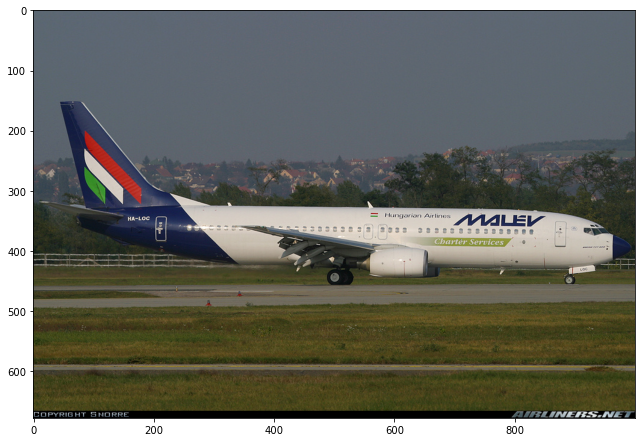

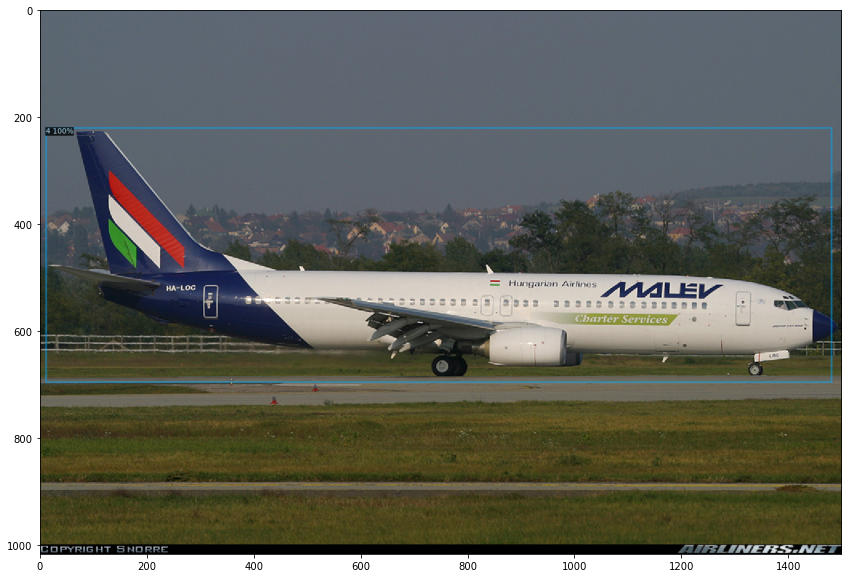

In [45]:
im = cv2.imread(test_image_file)
print(im.shape)
plt.figure(figsize=(15,7.5))
plt.imshow(im[..., ::-1])   

predictor = DefaultPredictor(cfg, model)

outputs = predictor(im[..., ::-1])
        
        
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.5)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(20,10))
plt.imshow(out.get_image()[..., ::-1][..., ::-1])

# Please continue to object_detection_class_imbalanced notebook